<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 2.4: Parameter estimation on GW150914 using open data.

This example estimates the non-spinning parameters of the binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_2/Tuto_2.4_Parameter_estimation_for_compact_object_mergers.ipynb)

More examples at https://lscsoft.docs.ligo.org/bilby/examples.html


##  Installation  (execute only if running on a cloud platform!)

In [ ]:
# -- Use the following line in Google Colab
#! pip install -q 'lalsuite==6.66' 'bilby==0.6.1' 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

We begin by importing some commonly used functions

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

Populating the interactive namespace from numpy and matplotlib


## Bilby version

In [3]:
print(bilby.__version__)

0.6.1:


In this notebook, we'll analyse GW150914, first we need to know the trigger time. This can be found on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/), here we define it as a variable

In [4]:
time_of_event = 1126259462.4

## Set up empty interferometers
We need to get some data to analyse. We'll be using data from the Hanford (H1) and Livinston (L1) ground-based gravitational wave detectors. To organise ourselves, we'll create two "empty" interferometers. These are empty in the sense that they don't have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO - we'll overwrite this later on, but it is often useful for simulations.

In [5]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

## Download the data

To analyse the signal, we need to download analyis data. Here, we will use [gwpy](https://gwpy.github.io/) to download the open strain data. For a general introduction to reading/writing data with gwpy, see [the documentation](https://gwpy.github.io/docs/stable/timeseries/).

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration of". That is, there is always 2s of data after the trigger time. We therefore define all times relative to the trigger time, duration and this post-trigger duration.

In [6]:
# Definite times in relatation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

/Users/sylviabiscoveanu/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Here, `H1_analysis_data` and its L1 counterpart are gwpy TimeSeries objects. As such, we can plot the data itself out:

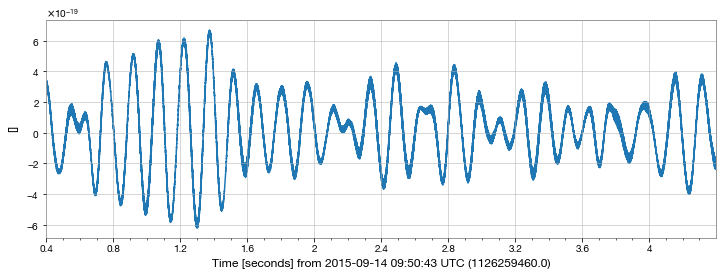

In [7]:
H1_analysis_data.plot()
plt.show()

This doesn't tell us much of course! It is dominated by the low frequency noise.

## Initialise the bilby inteferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` bilby inteferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods.

In [8]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

## Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data (for discussion on methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract)) 

Again, we need to download this from the open strain data. We start by figuring out the amount of data needed - in this case 32 times the analysis duration.

In [9]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

/Users/sylviabiscoveanu/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)


Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` applied to the strain data into the fractional value used by `gwpy`.

In [10]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

## Initialise the PSD
Now that we have psd's for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.

In [11]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

## Looking at the data
Okay, we have spent a bit of time now downloading and initializing things. Let's check that everything makes sense. To do this, we'll plot our analysis data alongwise the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

15:51 bilby INFO    : Generating frequency domain strain from given time domain strain.
15:51 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


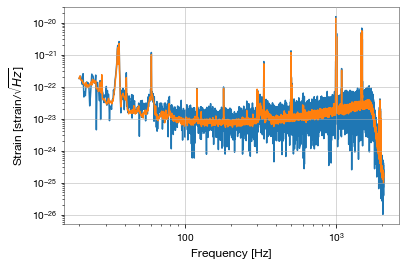

In [12]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artefact of the downsampling applied to the data - note that we downloaded the 4096Hz data which is downsamples for 16384Hz. We aren't really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [13]:
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024

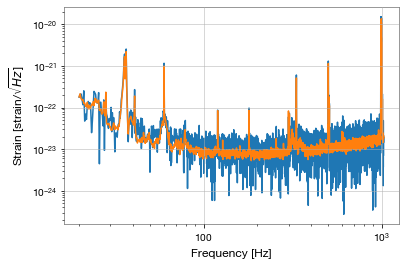

In [14]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

Okay, that is better - we now won't analyse any data near to the artefact produced by downsampling. Now we have some sensible data to analyse so let's get right on with down the analysis!

## Low dimensional analysis

As a start, let's run a short (~1min on a single 2.8GHz core), chirp-mass only parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, and only the chirp-mass is allowed to vary.

### Create a prior

Here, we create a prior - this defined the prior space we'll explore. In order to make things fast we set lots of parameters to fixed values

In [35]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


## Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a likelihood object. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby won't mind a bit!

Let's great a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [36]:
# First, put our "data" created above into a list of intererometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

16:18 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


### Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [39]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="GW150914_dist",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

16:39 bilby INFO    : Running for label 'GW150914_dist', output will be saved to 'short'
16:39 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
16:39 bilby INFO    : Search parameters:
16:39 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
16:39 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
16:39 bilby INFO    :   luminosity_distance = PowerLaw(alpha=2.0, minimum=50.0, maximum=800.0, name='luminosity_distance', latex_label='$d_L$', unit=None, boundary=None)
16:39 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.000244140625, name=None, latex_label=None, unit=None, boundary='periodic')
16:39 bilby INFO    :   phase = 0.0
16:39 b





0it [00:00, ?it/s]

16:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 1, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12333a850>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 1}
16:39 bilby INFO    : Checkpoint every n_check_point = 70000
16:39 bilby INFO    : Using dynesty version 1.0.1
16:40 bilby INFO    : Using the bilby-implemented rwalk sample method





1it [00:08,  8.11s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-996.28+/-0.17 dlogz:inf>3.00]



12it [00:08,  5.68s/it, bound:0 nc:1 ncall:513 eff:2.3% logz-ratio=158.71+/-0.14 dlogz:134.207>3.00]



22it [00:08,  3.98s/it, bound:0 nc:1 ncall:524 eff:4.2% logz-ratio=163.04+/-0.13 dlogz:129.248>3.00]



33it [00:08,  2.79s/it, bound:0 nc:1 ncall:536 eff:6.2% logz-ratio=165.71+/-0.12 dlogz:126.419>3.00]



44it [00:08,  1.96s/it, bound:0 nc:1 ncall:548 eff:8.0% logz-ratio=167.99+/-0.12 dlogz:124.100>3.00]



52it [00:08,  1.37s/it, bound:0 nc:1 ncall:557 eff:9.3% logz-ratio=169.56+/-0.12 dlogz:122.519>3.00]



60it [00:08,  1.04it/s, bound:0 nc:1 ncall:566 eff:10.6% logz-ratio=170.59+/-0.12 dlogz:121.373>3.00]



72it [00:08,  1.47it/s, bound:0 nc:2 ncall:579 eff:12.4% logz-ratio=171.69+/-0.11 dlogz:120.250>3.00]



83it [00:08,  2.09it/s, bound:0 nc:1 ncall:591 eff:14.0% logz-ratio=172.71+/-0.11 dlogz:119.222>3.00]



95it [00:09,  2.97it/s, bound:0 nc:2 ncall:604 eff:15.7% logz

525it [00:16, 46.24it/s, bound:0 nc:7 ncall:1461 eff:35.9% logz-ratio=211.33+/-0.12 dlogz:79.712>3.00]



530it [00:16, 39.63it/s, bound:0 nc:1 ncall:1482 eff:35.8% logz-ratio=211.62+/-0.12 dlogz:79.417>3.00]



535it [00:16, 38.89it/s, bound:0 nc:1 ncall:1499 eff:35.7% logz-ratio=211.92+/-0.12 dlogz:79.108>3.00]



540it [00:17, 41.19it/s, bound:0 nc:2 ncall:1512 eff:35.7% logz-ratio=212.28+/-0.12 dlogz:78.978>3.00]



547it [00:17, 46.69it/s, bound:0 nc:3 ncall:1525 eff:35.9% logz-ratio=212.84+/-0.12 dlogz:78.423>3.00]



553it [00:17, 43.18it/s, bound:0 nc:7 ncall:1545 eff:35.8% logz-ratio=213.33+/-0.12 dlogz:77.925>3.00]



559it [00:17, 45.82it/s, bound:0 nc:3 ncall:1559 eff:35.9% logz-ratio=213.84+/-0.12 dlogz:77.400>3.00]



564it [00:17, 45.25it/s, bound:0 nc:1 ncall:1573 eff:35.9% logz-ratio=214.29+/-0.12 dlogz:76.941>3.00]



569it [00:17, 42.98it/s, bound:0 nc:2 ncall:1589 eff:35.8% logz-ratio=214.68+/-0.12 dlogz:76.535>3.00]



574it [00:17, 40.77it/s, bound:0 nc:1 ncall:16

840it [00:26, 26.24it/s, bound:0 nc:17 ncall:2656 eff:31.6% logz-ratio=239.33+/-0.13 dlogz:52.196>3.00]



844it [00:26, 27.64it/s, bound:0 nc:4 ncall:2670 eff:31.6% logz-ratio=239.69+/-0.13 dlogz:51.827>3.00] 



848it [00:26, 28.88it/s, bound:0 nc:5 ncall:2682 eff:31.6% logz-ratio=240.00+/-0.13 dlogz:51.503>3.00]



852it [00:26, 25.07it/s, bound:0 nc:8 ncall:2702 eff:31.5% logz-ratio=240.36+/-0.13 dlogz:51.136>3.00]



855it [00:26, 22.47it/s, bound:0 nc:5 ncall:2720 eff:31.4% logz-ratio=240.61+/-0.13 dlogz:50.886>3.00]



858it [00:27, 20.56it/s, bound:0 nc:14 ncall:2741 eff:31.3% logz-ratio=240.88+/-0.13 dlogz:50.612>3.00]



862it [00:27, 21.79it/s, bound:0 nc:8 ncall:2760 eff:31.2% logz-ratio=241.21+/-0.13 dlogz:50.265>3.00] 



866it [00:27, 24.88it/s, bound:0 nc:6 ncall:2772 eff:31.2% logz-ratio=241.51+/-0.13 dlogz:49.940>3.00]



869it [00:27, 20.49it/s, bound:0 nc:8 ncall:2794 eff:31.1% logz-ratio=241.74+/-0.13 dlogz:49.710>3.00]



872it [00:27, 21.27it/s, bound:0 nc:2 ncal

1043it [00:39,  8.58it/s, bound:0 nc:4 ncall:4045 eff:25.8% logz-ratio=254.08+/-0.14 dlogz:37.317>3.00]



1045it [00:39,  9.50it/s, bound:0 nc:8 ncall:4055 eff:25.8% logz-ratio=254.23+/-0.14 dlogz:37.155>3.00]



1047it [00:39, 10.80it/s, bound:0 nc:3 ncall:4062 eff:25.8% logz-ratio=254.36+/-0.14 dlogz:37.008>3.00]



1049it [00:39,  9.06it/s, bound:0 nc:6 ncall:4090 eff:25.6% logz-ratio=254.50+/-0.14 dlogz:36.873>3.00]



1052it [00:39, 11.28it/s, bound:0 nc:2 ncall:4097 eff:25.7% logz-ratio=254.71+/-0.14 dlogz:36.652>3.00]



1054it [00:40, 11.76it/s, bound:0 nc:5 ncall:4109 eff:25.7% logz-ratio=254.84+/-0.14 dlogz:36.518>3.00]



1056it [00:40,  9.40it/s, bound:0 nc:19 ncall:4135 eff:25.5% logz-ratio=254.96+/-0.14 dlogz:36.388>3.00]



1058it [00:40, 10.41it/s, bound:0 nc:6 ncall:4146 eff:25.5% logz-ratio=255.10+/-0.14 dlogz:36.253>3.00] 



1060it [00:40,  7.85it/s, bound:0 nc:18 ncall:4172 eff:25.4% logz-ratio=255.24+/-0.14 dlogz:36.115>3.00]



1062it [00:41,  8.27it/s, bound:0 

1164it [00:54,  6.23it/s, bound:0 nc:14 ncall:5299 eff:22.0% logz-ratio=261.07+/-0.13 dlogz:30.037>3.00]



1165it [00:54,  6.77it/s, bound:0 nc:11 ncall:5310 eff:21.9% logz-ratio=261.11+/-0.13 dlogz:29.999>3.00]



1166it [00:54,  7.22it/s, bound:0 nc:13 ncall:5323 eff:21.9% logz-ratio=261.14+/-0.13 dlogz:29.961>3.00]



1168it [00:55,  7.32it/s, bound:0 nc:26 ncall:5353 eff:21.8% logz-ratio=261.21+/-0.13 dlogz:29.887>3.00]



1170it [00:55,  8.16it/s, bound:0 nc:15 ncall:5372 eff:21.8% logz-ratio=261.28+/-0.13 dlogz:29.814>3.00]



1171it [00:55,  4.45it/s, bound:0 nc:47 ncall:5419 eff:21.6% logz-ratio=261.31+/-0.13 dlogz:29.777>3.00]



1175it [00:55,  6.03it/s, bound:0 nc:2 ncall:5431 eff:21.6% logz-ratio=261.46+/-0.13 dlogz:29.631>3.00] 



1177it [00:55,  7.25it/s, bound:0 nc:1 ncall:5447 eff:21.6% logz-ratio=261.53+/-0.13 dlogz:29.553>3.00]



1179it [00:56,  7.34it/s, bound:0 nc:8 ncall:5473 eff:21.5% logz-ratio=261.61+/-0.13 dlogz:29.469>3.00]



1181it [00:56,  7.55it/s, boun

1292it [01:12,  9.29it/s, bound:0 nc:8 ncall:6901 eff:18.7% logz-ratio=266.48+/-0.13 dlogz:24.383>3.00]



1295it [01:12,  9.87it/s, bound:0 nc:20 ncall:6927 eff:18.7% logz-ratio=266.61+/-0.13 dlogz:24.242>3.00]



1297it [01:12,  9.16it/s, bound:0 nc:8 ncall:6949 eff:18.7% logz-ratio=266.70+/-0.14 dlogz:24.151>3.00] 



1301it [01:13, 10.06it/s, bound:0 nc:18 ncall:6973 eff:18.7% logz-ratio=266.87+/-0.14 dlogz:23.973>3.00]



1303it [01:13,  7.14it/s, bound:0 nc:15 ncall:7017 eff:18.6% logz-ratio=266.95+/-0.14 dlogz:23.887>3.00]



1304it [01:13,  5.50it/s, bound:0 nc:24 ncall:7041 eff:18.5% logz-ratio=266.99+/-0.14 dlogz:23.842>3.00]



1307it [01:13,  6.76it/s, bound:0 nc:10 ncall:7055 eff:18.5% logz-ratio=267.12+/-0.14 dlogz:23.709>3.00]



1310it [01:14,  8.20it/s, bound:0 nc:7 ncall:7070 eff:18.5% logz-ratio=267.24+/-0.14 dlogz:23.582>3.00] 



1312it [01:14,  7.56it/s, bound:0 nc:4 ncall:7095 eff:18.5% logz-ratio=267.32+/-0.14 dlogz:23.496>3.00]



1314it [01:14,  8.21it/s, boun

1408it [01:30,  5.91it/s, bound:0 nc:19 ncall:8570 eff:16.4% logz-ratio=270.66+/-0.14 dlogz:20.429>3.00]



1409it [01:30,  3.57it/s, bound:0 nc:35 ncall:8605 eff:16.4% logz-ratio=270.69+/-0.14 dlogz:20.397>3.00]



1410it [01:31,  4.11it/s, bound:0 nc:9 ncall:8614 eff:16.4% logz-ratio=270.72+/-0.14 dlogz:20.366>3.00] 



1412it [01:31,  4.90it/s, bound:0 nc:21 ncall:8637 eff:16.3% logz-ratio=270.78+/-0.14 dlogz:20.304>3.00]



1413it [01:31,  3.85it/s, bound:0 nc:39 ncall:8676 eff:16.3% logz-ratio=270.81+/-0.14 dlogz:20.270>3.00]



1415it [01:31,  4.88it/s, bound:0 nc:8 ncall:8692 eff:16.3% logz-ratio=270.87+/-0.14 dlogz:20.204>3.00] 



1416it [01:31,  5.51it/s, bound:0 nc:12 ncall:8704 eff:16.3% logz-ratio=270.91+/-0.14 dlogz:20.169>3.00]



1417it [01:32,  5.94it/s, bound:0 nc:13 ncall:8717 eff:16.3% logz-ratio=270.94+/-0.14 dlogz:20.135>3.00]



1418it [01:32,  4.08it/s, bound:0 nc:36 ncall:8753 eff:16.2% logz-ratio=270.97+/-0.14 dlogz:20.101>3.00]



1419it [01:32,  4.76it/s, bo

1514it [01:49,  5.33it/s, bound:0 nc:19 ncall:10332 eff:14.7% logz-ratio=273.61+/-0.13 dlogz:17.431>3.00]



1515it [01:49,  6.06it/s, bound:0 nc:11 ncall:10343 eff:14.6% logz-ratio=273.64+/-0.13 dlogz:17.407>3.00]



1516it [01:49,  5.90it/s, bound:0 nc:19 ncall:10362 eff:14.6% logz-ratio=273.66+/-0.13 dlogz:17.382>3.00]



1518it [01:50,  7.30it/s, bound:0 nc:12 ncall:10375 eff:14.6% logz-ratio=273.70+/-0.13 dlogz:17.334>3.00]



1519it [01:50,  5.71it/s, bound:0 nc:28 ncall:10403 eff:14.6% logz-ratio=273.73+/-0.13 dlogz:17.310>3.00]



1520it [01:51,  2.28it/s, bound:0 nc:110 ncall:10513 eff:14.5% logz-ratio=273.75+/-0.13 dlogz:17.286>3.00]



1521it [01:51,  2.47it/s, bound:0 nc:34 ncall:10547 eff:14.4% logz-ratio=273.77+/-0.13 dlogz:17.262>3.00] 



1523it [01:52,  2.86it/s, bound:0 nc:47 ncall:10597 eff:14.4% logz-ratio=273.81+/-0.13 dlogz:17.216>3.00]



1526it [01:52,  3.56it/s, bound:0 nc:30 ncall:10634 eff:14.4% logz-ratio=273.87+/-0.13 dlogz:17.148>3.00]



1527it [01:52,  3

1619it [02:08,  7.36it/s, bound:0 nc:15 ncall:12340 eff:13.1% logz-ratio=275.67+/-0.13 dlogz:15.168>3.00]



1621it [02:08,  8.39it/s, bound:0 nc:12 ncall:12358 eff:13.1% logz-ratio=275.71+/-0.13 dlogz:15.124>3.00]



1623it [02:08,  9.13it/s, bound:0 nc:2 ncall:12378 eff:13.1% logz-ratio=275.75+/-0.13 dlogz:15.080>3.00] 



1625it [02:09,  5.56it/s, bound:0 nc:16 ncall:12459 eff:13.0% logz-ratio=275.79+/-0.13 dlogz:15.034>3.00]



1626it [02:09,  5.29it/s, bound:0 nc:24 ncall:12483 eff:13.0% logz-ratio=275.81+/-0.13 dlogz:15.011>3.00]



1627it [02:09,  6.07it/s, bound:0 nc:12 ncall:12495 eff:13.0% logz-ratio=275.83+/-0.13 dlogz:14.988>3.00]



1628it [02:10,  4.33it/s, bound:0 nc:41 ncall:12536 eff:13.0% logz-ratio=275.85+/-0.13 dlogz:14.965>3.00]



1629it [02:10,  4.24it/s, bound:0 nc:21 ncall:12557 eff:13.0% logz-ratio=275.87+/-0.13 dlogz:14.943>3.00]



1630it [02:11,  2.92it/s, bound:0 nc:59 ncall:12616 eff:12.9% logz-ratio=275.89+/-0.13 dlogz:14.922>3.00]



1631it [02:11,  3.2

1706it [02:31,  2.68it/s, bound:0 nc:77 ncall:14791 eff:11.5% logz-ratio=277.30+/-0.13 dlogz:13.354>3.00]



1707it [02:31,  3.05it/s, bound:0 nc:24 ncall:14815 eff:11.5% logz-ratio=277.32+/-0.13 dlogz:13.335>3.00]



1710it [02:32,  3.51it/s, bound:0 nc:50 ncall:14875 eff:11.5% logz-ratio=277.37+/-0.13 dlogz:13.277>3.00]



1711it [02:33,  1.88it/s, bound:0 nc:119 ncall:14994 eff:11.4% logz-ratio=277.39+/-0.13 dlogz:13.258>3.00]



1712it [02:33,  2.13it/s, bound:0 nc:38 ncall:15032 eff:11.4% logz-ratio=277.41+/-0.13 dlogz:13.239>3.00] 



1713it [02:33,  2.67it/s, bound:0 nc:17 ncall:15049 eff:11.4% logz-ratio=277.42+/-0.13 dlogz:13.220>3.00]



1715it [02:34,  2.41it/s, bound:0 nc:110 ncall:15161 eff:11.3% logz-ratio=277.46+/-0.13 dlogz:13.182>3.00]



1716it [02:36,  1.56it/s, bound:0 nc:124 ncall:15285 eff:11.2% logz-ratio=277.47+/-0.13 dlogz:13.164>3.00]



1717it [02:36,  1.98it/s, bound:0 nc:19 ncall:15304 eff:11.2% logz-ratio=277.49+/-0.13 dlogz:13.146>3.00] 



1718it [02:36,

1790it [02:57,  2.07it/s, bound:0 nc:69 ncall:17594 eff:10.2% logz-ratio=278.63+/-0.14 dlogz:11.858>3.00]



1791it [02:57,  2.58it/s, bound:0 nc:15 ncall:17609 eff:10.2% logz-ratio=278.65+/-0.14 dlogz:11.838>3.00]



1792it [02:57,  2.70it/s, bound:0 nc:38 ncall:17647 eff:10.2% logz-ratio=278.67+/-0.14 dlogz:11.819>3.00]



1793it [02:58,  1.93it/s, bound:0 nc:97 ncall:17744 eff:10.1% logz-ratio=278.68+/-0.14 dlogz:11.800>3.00]



1794it [02:59,  1.89it/s, bound:0 nc:58 ncall:17802 eff:10.1% logz-ratio=278.70+/-0.14 dlogz:11.781>3.00]



1796it [02:59,  2.23it/s, bound:0 nc:55 ncall:17866 eff:10.1% logz-ratio=278.73+/-0.14 dlogz:11.743>3.00]



1797it [03:00,  2.16it/s, bound:0 nc:63 ncall:17929 eff:10.0% logz-ratio=278.75+/-0.14 dlogz:11.725>3.00]



1798it [03:00,  2.49it/s, bound:0 nc:31 ncall:17960 eff:10.0% logz-ratio=278.77+/-0.14 dlogz:11.706>3.00]



1799it [03:01,  1.87it/s, bound:0 nc:106 ncall:18066 eff:10.0% logz-ratio=278.78+/-0.14 dlogz:11.687>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain






1800it [03:01,  2.48it/s, bound:1 nc:4 ncall:18070 eff:10.0% logz-ratio=278.80+/-0.14 dlogz:11.669>3.00]  

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1803it [03:01,  3.39it/s, bound:1 nc:4 ncall:18081 eff:10.0% logz-ratio=278.85+/-0.14 dlogz:11.615>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1805it [03:01,  4.43it/s, bound:1 nc:8 ncall:18093 eff:10.0% logz-ratio=278.88+/-0.14 dlogz:11.579>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1807it [03:01,  5.74it/s, bound:1 nc:6 ncall:18102 eff:10.0% logz-ratio=278.91+/-0.14 dlogz:11.544>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1809it [03:01,  7.28it/s, bound:1 nc:4 ncall:18111 eff:10.0% logz-ratio=278.94+/-0.14 dlogz:11.510>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1812it [03:02,  9.20it/s, bound:1 nc:3 ncall:18121 eff:10.0% logz-ratio=278.99+/-0.14 dlogz:11.458>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1815it [03:02, 11.49it/s, bound:1 nc:2 ncall:18129 eff:10.0% logz-ratio=279.03+/-0.14 dlogz:11.407>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1818it [03:02, 14.08it/s, bound:1 nc:2 ncall:18137 eff:10.0% logz-ratio=279.08+/-0.14 dlogz:11.355>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1821it [03:02, 15.36it/s, bound:1 nc:2 ncall:18151 eff:10.0% logz-ratio=279.12+/-0.14 dlogz:11.306>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1825it [03:02, 18.07it/s, bound:1 nc:3 ncall:18161 eff:10.0% logz-ratio=279.18+/-0.14 dlogz:11.240>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1828it [03:02, 18.77it/s, bound:1 nc:5 ncall:18174 eff:10.1% logz-ratio=279.22+/-0.14 dlogz:11.189>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1831it [03:02, 20.60it/s, bound:1 nc:3 ncall:18183 eff:10.1% logz-ratio=279.26+/-0.14 dlogz:11.140>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain
16:42 bilby WARNING : Returning random point in second half of the chain






1834it [03:02, 20.93it/s, bound:1 nc:2 ncall:18194 eff:10.1% logz-ratio=279.31+/-0.14 dlogz:11.091>3.00]

16:42 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1837it [03:03, 20.62it/s, bound:1 nc:3 ncall:18206 eff:10.1% logz-ratio=279.35+/-0.14 dlogz:11.044>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1840it [03:03, 21.18it/s, bound:1 nc:2 ncall:18217 eff:10.1% logz-ratio=279.39+/-0.14 dlogz:10.996>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1844it [03:03, 22.59it/s, bound:1 nc:5 ncall:18229 eff:10.1% logz-ratio=279.44+/-0.14 dlogz:10.934>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1847it [03:03, 24.12it/s, bound:1 nc:3 ncall:18237 eff:10.1% logz-ratio=279.48+/-0.14 dlogz:10.887>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1850it [03:03, 24.77it/s, bound:1 nc:4 ncall:18245 eff:10.1% logz-ratio=279.52+/-0.14 dlogz:10.841>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1853it [03:03, 25.71it/s, bound:1 nc:3 ncall:18253 eff:10.2% logz-ratio=279.56+/-0.14 dlogz:10.798>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1856it [03:03, 22.40it/s, bound:1 nc:10 ncall:18269 eff:10.2% logz-ratio=279.60+/-0.14 dlogz:10.754>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1859it [03:03, 23.74it/s, bound:1 nc:2 ncall:18277 eff:10.2% logz-ratio=279.64+/-0.14 dlogz:10.711>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1862it [03:04, 22.12it/s, bound:1 nc:3 ncall:18291 eff:10.2% logz-ratio=279.67+/-0.14 dlogz:10.669>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1865it [03:04, 19.17it/s, bound:1 nc:5 ncall:18311 eff:10.2% logz-ratio=279.71+/-0.14 dlogz:10.626>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1868it [03:04, 19.28it/s, bound:1 nc:8 ncall:18325 eff:10.2% logz-ratio=279.75+/-0.14 dlogz:10.584>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1871it [03:04, 16.90it/s, bound:1 nc:4 ncall:18348 eff:10.2% logz-ratio=279.78+/-0.14 dlogz:10.541>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1873it [03:04, 17.15it/s, bound:1 nc:5 ncall:18358 eff:10.2% logz-ratio=279.81+/-0.14 dlogz:10.513>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1876it [03:04, 19.18it/s, bound:1 nc:3 ncall:18367 eff:10.2% logz-ratio=279.84+/-0.14 dlogz:10.472>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1879it [03:05, 19.82it/s, bound:2 nc:2 ncall:18378 eff:10.2% logz-ratio=279.87+/-0.14 dlogz:10.432>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1882it [03:05, 20.26it/s, bound:2 nc:4 ncall:18390 eff:10.2% logz-ratio=279.91+/-0.14 dlogz:10.392>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1885it [03:05, 19.58it/s, bound:2 nc:5 ncall:18405 eff:10.2% logz-ratio=279.94+/-0.14 dlogz:10.352>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1888it [03:05, 19.39it/s, bound:2 nc:7 ncall:18420 eff:10.2% logz-ratio=279.97+/-0.14 dlogz:10.313>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1890it [03:05, 19.41it/s, bound:2 nc:6 ncall:18429 eff:10.3% logz-ratio=280.00+/-0.14 dlogz:10.287>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1893it [03:05, 20.86it/s, bound:2 nc:2 ncall:18439 eff:10.3% logz-ratio=280.03+/-0.14 dlogz:10.249>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1896it [03:05, 22.71it/s, bound:2 nc:2 ncall:18447 eff:10.3% logz-ratio=280.06+/-0.14 dlogz:10.211>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1899it [03:06, 19.92it/s, bound:2 nc:8 ncall:18465 eff:10.3% logz-ratio=280.09+/-0.13 dlogz:10.173>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1902it [03:06, 19.09it/s, bound:2 nc:5 ncall:18479 eff:10.3% logz-ratio=280.12+/-0.13 dlogz:10.134>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1905it [03:06, 20.00it/s, bound:2 nc:4 ncall:18488 eff:10.3% logz-ratio=280.16+/-0.13 dlogz:10.096>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1908it [03:06, 19.63it/s, bound:2 nc:5 ncall:18501 eff:10.3% logz-ratio=280.19+/-0.13 dlogz:10.058>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1911it [03:06, 20.03it/s, bound:2 nc:3 ncall:18512 eff:10.3% logz-ratio=280.22+/-0.13 dlogz:10.020>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1914it [03:06, 20.91it/s, bound:2 nc:4 ncall:18522 eff:10.3% logz-ratio=280.25+/-0.13 dlogz:9.982>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1917it [03:06, 20.85it/s, bound:2 nc:5 ncall:18534 eff:10.3% logz-ratio=280.28+/-0.13 dlogz:9.944>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1920it [03:07, 21.93it/s, bound:2 nc:2 ncall:18543 eff:10.4% logz-ratio=280.32+/-0.13 dlogz:9.907>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1923it [03:07, 21.85it/s, bound:2 nc:4 ncall:18554 eff:10.4% logz-ratio=280.35+/-0.13 dlogz:9.870>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1926it [03:07, 21.06it/s, bound:2 nc:3 ncall:18567 eff:10.4% logz-ratio=280.38+/-0.13 dlogz:9.833>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1929it [03:07, 20.71it/s, bound:2 nc:4 ncall:18579 eff:10.4% logz-ratio=280.41+/-0.13 dlogz:9.795>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1932it [03:07, 20.89it/s, bound:2 nc:6 ncall:18590 eff:10.4% logz-ratio=280.44+/-0.13 dlogz:9.757>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1935it [03:07, 21.27it/s, bound:2 nc:2 ncall:18601 eff:10.4% logz-ratio=280.48+/-0.13 dlogz:9.718>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1938it [03:07, 20.30it/s, bound:2 nc:6 ncall:18615 eff:10.4% logz-ratio=280.51+/-0.13 dlogz:9.679>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1941it [03:08, 19.64it/s, bound:2 nc:8 ncall:18629 eff:10.4% logz-ratio=280.54+/-0.13 dlogz:9.640>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1944it [03:08, 21.79it/s, bound:2 nc:2 ncall:18635 eff:10.4% logz-ratio=280.57+/-0.13 dlogz:9.602>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1947it [03:08, 19.08it/s, bound:2 nc:2 ncall:18650 eff:10.4% logz-ratio=280.61+/-0.13 dlogz:9.564>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1950it [03:08, 18.04it/s, bound:2 nc:4 ncall:18661 eff:10.4% logz-ratio=280.64+/-0.13 dlogz:9.525>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1952it [03:08, 14.51it/s, bound:3 nc:4 ncall:18675 eff:10.5% logz-ratio=280.66+/-0.13 dlogz:9.499>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1954it [03:08, 15.22it/s, bound:3 nc:4 ncall:18682 eff:10.5% logz-ratio=280.68+/-0.13 dlogz:9.473>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1957it [03:09, 16.97it/s, bound:3 nc:4 ncall:18690 eff:10.5% logz-ratio=280.72+/-0.13 dlogz:9.433>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1960it [03:09, 19.12it/s, bound:3 nc:3 ncall:18697 eff:10.5% logz-ratio=280.75+/-0.13 dlogz:9.393>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1963it [03:09, 17.98it/s, bound:3 nc:4 ncall:18713 eff:10.5% logz-ratio=280.78+/-0.13 dlogz:9.354>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1965it [03:09, 18.06it/s, bound:3 nc:3 ncall:18720 eff:10.5% logz-ratio=280.81+/-0.14 dlogz:9.327>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1968it [03:09, 20.32it/s, bound:3 nc:2 ncall:18728 eff:10.5% logz-ratio=280.84+/-0.14 dlogz:9.288>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1971it [03:09, 20.97it/s, bound:3 nc:3 ncall:18738 eff:10.5% logz-ratio=280.87+/-0.14 dlogz:9.249>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1974it [03:09, 20.67it/s, bound:3 nc:4 ncall:18749 eff:10.5% logz-ratio=280.90+/-0.14 dlogz:9.211>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1977it [03:09, 22.06it/s, bound:3 nc:5 ncall:18758 eff:10.5% logz-ratio=280.94+/-0.14 dlogz:9.172>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1980it [03:10, 22.44it/s, bound:3 nc:2 ncall:18766 eff:10.6% logz-ratio=280.97+/-0.14 dlogz:9.132>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1983it [03:10, 21.23it/s, bound:3 nc:3 ncall:18776 eff:10.6% logz-ratio=281.01+/-0.14 dlogz:9.092>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1986it [03:10, 20.06it/s, bound:3 nc:4 ncall:18789 eff:10.6% logz-ratio=281.04+/-0.14 dlogz:9.054>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1989it [03:10, 20.72it/s, bound:3 nc:4 ncall:18799 eff:10.6% logz-ratio=281.07+/-0.14 dlogz:9.016>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1992it [03:10, 22.63it/s, bound:3 nc:2 ncall:18807 eff:10.6% logz-ratio=281.10+/-0.14 dlogz:8.979>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1995it [03:10, 22.79it/s, bound:3 nc:4 ncall:18818 eff:10.6% logz-ratio=281.13+/-0.14 dlogz:8.941>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






1998it [03:10, 20.38it/s, bound:3 nc:3 ncall:18834 eff:10.6% logz-ratio=281.16+/-0.14 dlogz:8.903>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2001it [03:11, 20.32it/s, bound:3 nc:3 ncall:18847 eff:10.6% logz-ratio=281.20+/-0.14 dlogz:8.865>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2004it [03:11, 20.42it/s, bound:3 nc:3 ncall:18860 eff:10.6% logz-ratio=281.23+/-0.14 dlogz:8.828>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2007it [03:11, 19.37it/s, bound:3 nc:3 ncall:18876 eff:10.6% logz-ratio=281.26+/-0.14 dlogz:8.790>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2010it [03:11, 20.71it/s, bound:3 nc:5 ncall:18886 eff:10.6% logz-ratio=281.29+/-0.14 dlogz:8.753>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2013it [03:11, 19.96it/s, bound:3 nc:5 ncall:18899 eff:10.7% logz-ratio=281.32+/-0.14 dlogz:8.717>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2016it [03:11, 19.62it/s, bound:3 nc:6 ncall:18911 eff:10.7% logz-ratio=281.35+/-0.14 dlogz:8.680>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2018it [03:12, 19.09it/s, bound:3 nc:3 ncall:18918 eff:10.7% logz-ratio=281.37+/-0.14 dlogz:8.655>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2020it [03:12, 16.86it/s, bound:3 nc:6 ncall:18928 eff:10.7% logz-ratio=281.39+/-0.14 dlogz:8.631>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2023it [03:12, 17.73it/s, bound:3 nc:4 ncall:18939 eff:10.7% logz-ratio=281.42+/-0.14 dlogz:8.595>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2025it [03:12, 16.29it/s, bound:3 nc:8 ncall:18949 eff:10.7% logz-ratio=281.44+/-0.14 dlogz:8.572>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2027it [03:12, 16.35it/s, bound:3 nc:5 ncall:18957 eff:10.7% logz-ratio=281.46+/-0.14 dlogz:8.548>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2029it [03:12, 15.39it/s, bound:3 nc:5 ncall:18966 eff:10.7% logz-ratio=281.48+/-0.14 dlogz:8.525>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2031it [03:12, 14.15it/s, bound:3 nc:9 ncall:18978 eff:10.7% logz-ratio=281.50+/-0.14 dlogz:8.502>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2033it [03:12, 15.42it/s, bound:4 nc:4 ncall:18986 eff:10.7% logz-ratio=281.52+/-0.14 dlogz:8.479>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2035it [03:13, 16.32it/s, bound:4 nc:4 ncall:18995 eff:10.7% logz-ratio=281.54+/-0.14 dlogz:8.456>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2037it [03:13, 16.90it/s, bound:4 nc:2 ncall:19001 eff:10.7% logz-ratio=281.56+/-0.14 dlogz:8.433>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2039it [03:13, 17.35it/s, bound:4 nc:3 ncall:19006 eff:10.7% logz-ratio=281.57+/-0.14 dlogz:8.410>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2041it [03:13, 17.70it/s, bound:4 nc:3 ncall:19013 eff:10.7% logz-ratio=281.59+/-0.14 dlogz:8.387>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2044it [03:13, 18.33it/s, bound:4 nc:6 ncall:19026 eff:10.7% logz-ratio=281.62+/-0.14 dlogz:8.352>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2046it [03:13, 16.04it/s, bound:4 nc:6 ncall:19038 eff:10.7% logz-ratio=281.64+/-0.14 dlogz:8.329>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2048it [03:13, 14.35it/s, bound:4 nc:4 ncall:19052 eff:10.7% logz-ratio=281.66+/-0.14 dlogz:8.306>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2050it [03:14, 14.40it/s, bound:4 nc:6 ncall:19064 eff:10.8% logz-ratio=281.68+/-0.14 dlogz:8.283>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2053it [03:14, 16.04it/s, bound:4 nc:6 ncall:19076 eff:10.8% logz-ratio=281.71+/-0.14 dlogz:8.249>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2055it [03:14, 16.05it/s, bound:4 nc:8 ncall:19088 eff:10.8% logz-ratio=281.73+/-0.14 dlogz:8.226>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2057it [03:14, 16.99it/s, bound:4 nc:7 ncall:19097 eff:10.8% logz-ratio=281.75+/-0.14 dlogz:8.203>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2060it [03:14, 18.33it/s, bound:4 nc:6 ncall:19109 eff:10.8% logz-ratio=281.77+/-0.14 dlogz:8.169>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2062it [03:14, 15.66it/s, bound:4 nc:4 ncall:19127 eff:10.8% logz-ratio=281.79+/-0.14 dlogz:8.146>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2065it [03:14, 16.72it/s, bound:4 nc:7 ncall:19141 eff:10.8% logz-ratio=281.82+/-0.14 dlogz:8.112>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2068it [03:15, 17.77it/s, bound:4 nc:6 ncall:19154 eff:10.8% logz-ratio=281.85+/-0.14 dlogz:8.079>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2070it [03:15, 16.01it/s, bound:4 nc:6 ncall:19169 eff:10.8% logz-ratio=281.87+/-0.14 dlogz:8.056>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2073it [03:15, 16.38it/s, bound:4 nc:11 ncall:19186 eff:10.8% logz-ratio=281.89+/-0.14 dlogz:8.023>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2075it [03:15, 17.03it/s, bound:4 nc:4 ncall:19195 eff:10.8% logz-ratio=281.91+/-0.14 dlogz:8.001>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2077it [03:15, 17.76it/s, bound:4 nc:5 ncall:19204 eff:10.8% logz-ratio=281.93+/-0.14 dlogz:7.979>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2080it [03:15, 18.93it/s, bound:4 nc:4 ncall:19215 eff:10.8% logz-ratio=281.96+/-0.14 dlogz:7.945>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2082it [03:15, 17.90it/s, bound:4 nc:4 ncall:19225 eff:10.8% logz-ratio=281.97+/-0.14 dlogz:7.923>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2084it [03:15, 15.00it/s, bound:4 nc:6 ncall:19235 eff:10.8% logz-ratio=281.99+/-0.14 dlogz:7.901>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2086it [03:16, 14.31it/s, bound:4 nc:3 ncall:19248 eff:10.8% logz-ratio=282.01+/-0.14 dlogz:7.879>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2089it [03:16, 16.20it/s, bound:4 nc:4 ncall:19258 eff:10.8% logz-ratio=282.04+/-0.14 dlogz:7.846>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2092it [03:16, 17.38it/s, bound:4 nc:4 ncall:19268 eff:10.9% logz-ratio=282.06+/-0.14 dlogz:7.813>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2094it [03:16, 17.77it/s, bound:4 nc:3 ncall:19274 eff:10.9% logz-ratio=282.08+/-0.14 dlogz:7.792>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2096it [03:16, 16.77it/s, bound:5 nc:4 ncall:19283 eff:10.9% logz-ratio=282.10+/-0.14 dlogz:7.770>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2098it [03:16, 15.90it/s, bound:5 nc:8 ncall:19295 eff:10.9% logz-ratio=282.12+/-0.14 dlogz:7.748>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2100it [03:16, 14.81it/s, bound:5 nc:5 ncall:19310 eff:10.9% logz-ratio=282.13+/-0.14 dlogz:7.727>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2103it [03:17, 16.48it/s, bound:5 nc:4 ncall:19321 eff:10.9% logz-ratio=282.16+/-0.14 dlogz:7.696>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2106it [03:17, 17.74it/s, bound:5 nc:4 ncall:19333 eff:10.9% logz-ratio=282.18+/-0.14 dlogz:7.665>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2108it [03:17, 18.00it/s, bound:5 nc:4 ncall:19340 eff:10.9% logz-ratio=282.20+/-0.14 dlogz:7.644>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2110it [03:17, 17.14it/s, bound:5 nc:6 ncall:19350 eff:10.9% logz-ratio=282.22+/-0.14 dlogz:7.623>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2113it [03:17, 19.04it/s, bound:5 nc:3 ncall:19359 eff:10.9% logz-ratio=282.24+/-0.14 dlogz:7.592>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2116it [03:17, 18.16it/s, bound:5 nc:3 ncall:19375 eff:10.9% logz-ratio=282.27+/-0.14 dlogz:7.561>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2119it [03:17, 19.66it/s, bound:5 nc:3 ncall:19385 eff:10.9% logz-ratio=282.29+/-0.14 dlogz:7.531>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2122it [03:18, 17.81it/s, bound:5 nc:4 ncall:19402 eff:10.9% logz-ratio=282.32+/-0.14 dlogz:7.500>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2125it [03:18, 18.88it/s, bound:5 nc:4 ncall:19411 eff:10.9% logz-ratio=282.34+/-0.14 dlogz:7.469>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2127it [03:18, 15.50it/s, bound:5 nc:6 ncall:19426 eff:10.9% logz-ratio=282.36+/-0.14 dlogz:7.449>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2129it [03:18, 15.76it/s, bound:5 nc:5 ncall:19436 eff:11.0% logz-ratio=282.37+/-0.14 dlogz:7.429>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2131it [03:18, 16.26it/s, bound:5 nc:4 ncall:19445 eff:11.0% logz-ratio=282.39+/-0.14 dlogz:7.409>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2133it [03:18, 16.91it/s, bound:5 nc:4 ncall:19453 eff:11.0% logz-ratio=282.41+/-0.14 dlogz:7.389>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2136it [03:18, 17.92it/s, bound:5 nc:4 ncall:19464 eff:11.0% logz-ratio=282.43+/-0.14 dlogz:7.359>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2138it [03:18, 18.29it/s, bound:5 nc:4 ncall:19472 eff:11.0% logz-ratio=282.45+/-0.14 dlogz:7.340>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2140it [03:19, 18.25it/s, bound:5 nc:5 ncall:19480 eff:11.0% logz-ratio=282.46+/-0.14 dlogz:7.320>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2142it [03:19, 16.75it/s, bound:5 nc:4 ncall:19488 eff:11.0% logz-ratio=282.48+/-0.14 dlogz:7.300>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2144it [03:19, 16.78it/s, bound:5 nc:2 ncall:19496 eff:11.0% logz-ratio=282.49+/-0.14 dlogz:7.281>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2146it [03:19, 17.06it/s, bound:5 nc:5 ncall:19506 eff:11.0% logz-ratio=282.51+/-0.14 dlogz:7.261>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2149it [03:19, 18.83it/s, bound:5 nc:3 ncall:19516 eff:11.0% logz-ratio=282.53+/-0.14 dlogz:7.232>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2152it [03:19, 20.18it/s, bound:5 nc:2 ncall:19524 eff:11.0% logz-ratio=282.55+/-0.14 dlogz:7.202>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2155it [03:19, 17.95it/s, bound:5 nc:14 ncall:19544 eff:11.0% logz-ratio=282.58+/-0.14 dlogz:7.173>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2157it [03:20, 17.99it/s, bound:5 nc:5 ncall:19554 eff:11.0% logz-ratio=282.59+/-0.14 dlogz:7.154>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2159it [03:20, 17.32it/s, bound:5 nc:6 ncall:19565 eff:11.0% logz-ratio=282.61+/-0.14 dlogz:7.135>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2162it [03:20, 18.31it/s, bound:5 nc:4 ncall:19577 eff:11.0% logz-ratio=282.63+/-0.14 dlogz:7.106>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2165it [03:20, 19.73it/s, bound:6 nc:4 ncall:19586 eff:11.1% logz-ratio=282.65+/-0.14 dlogz:7.077>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2168it [03:20, 20.67it/s, bound:6 nc:5 ncall:19597 eff:11.1% logz-ratio=282.68+/-0.14 dlogz:7.048>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2171it [03:20, 17.59it/s, bound:6 nc:6 ncall:19617 eff:11.1% logz-ratio=282.70+/-0.14 dlogz:7.020>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2174it [03:20, 18.87it/s, bound:6 nc:4 ncall:19629 eff:11.1% logz-ratio=282.72+/-0.14 dlogz:6.992>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2176it [03:21, 17.03it/s, bound:6 nc:6 ncall:19644 eff:11.1% logz-ratio=282.74+/-0.14 dlogz:6.973>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2179it [03:21, 19.14it/s, bound:6 nc:4 ncall:19653 eff:11.1% logz-ratio=282.76+/-0.14 dlogz:6.944>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2182it [03:21, 17.95it/s, bound:6 nc:4 ncall:19670 eff:11.1% logz-ratio=282.78+/-0.14 dlogz:6.915>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2184it [03:21, 16.99it/s, bound:6 nc:4 ncall:19678 eff:11.1% logz-ratio=282.80+/-0.14 dlogz:6.896>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2186it [03:21, 15.35it/s, bound:6 nc:7 ncall:19688 eff:11.1% logz-ratio=282.81+/-0.14 dlogz:6.877>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2188it [03:21, 14.73it/s, bound:6 nc:4 ncall:19697 eff:11.1% logz-ratio=282.83+/-0.14 dlogz:6.858>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2190it [03:21, 15.45it/s, bound:6 nc:3 ncall:19703 eff:11.1% logz-ratio=282.84+/-0.14 dlogz:6.838>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2192it [03:22, 15.62it/s, bound:6 nc:3 ncall:19711 eff:11.1% logz-ratio=282.86+/-0.14 dlogz:6.819>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2194it [03:22, 15.10it/s, bound:6 nc:3 ncall:19720 eff:11.1% logz-ratio=282.87+/-0.14 dlogz:6.801>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2196it [03:22, 14.13it/s, bound:6 nc:10 ncall:19735 eff:11.1% logz-ratio=282.89+/-0.14 dlogz:6.782>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2198it [03:22, 14.44it/s, bound:6 nc:7 ncall:19747 eff:11.1% logz-ratio=282.90+/-0.14 dlogz:6.763>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2200it [03:22, 13.71it/s, bound:6 nc:9 ncall:19758 eff:11.1% logz-ratio=282.92+/-0.14 dlogz:6.745>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2202it [03:22, 13.65it/s, bound:6 nc:4 ncall:19766 eff:11.1% logz-ratio=282.93+/-0.14 dlogz:6.726>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2204it [03:22, 13.99it/s, bound:6 nc:4 ncall:19773 eff:11.1% logz-ratio=282.95+/-0.14 dlogz:6.708>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2206it [03:23, 14.66it/s, bound:6 nc:2 ncall:19779 eff:11.2% logz-ratio=282.96+/-0.14 dlogz:6.690>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2208it [03:23, 15.21it/s, bound:6 nc:3 ncall:19786 eff:11.2% logz-ratio=282.97+/-0.14 dlogz:6.672>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2210it [03:23, 16.30it/s, bound:6 nc:2 ncall:19792 eff:11.2% logz-ratio=282.99+/-0.14 dlogz:6.653>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2213it [03:23, 16.93it/s, bound:6 nc:5 ncall:19803 eff:11.2% logz-ratio=283.01+/-0.14 dlogz:6.626>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2215it [03:23, 14.52it/s, bound:6 nc:6 ncall:19817 eff:11.2% logz-ratio=283.02+/-0.14 dlogz:6.607>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2218it [03:23, 16.14it/s, bound:6 nc:5 ncall:19827 eff:11.2% logz-ratio=283.05+/-0.14 dlogz:6.654>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2220it [03:23, 16.73it/s, bound:6 nc:4 ncall:19836 eff:11.2% logz-ratio=283.06+/-0.14 dlogz:6.635>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2222it [03:24, 15.85it/s, bound:6 nc:2 ncall:19847 eff:11.2% logz-ratio=283.08+/-0.14 dlogz:6.616>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2224it [03:24, 15.10it/s, bound:6 nc:3 ncall:19860 eff:11.2% logz-ratio=283.09+/-0.14 dlogz:6.598>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2227it [03:24, 17.33it/s, bound:6 nc:3 ncall:19869 eff:11.2% logz-ratio=283.11+/-0.14 dlogz:6.571>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2230it [03:24, 18.07it/s, bound:6 nc:5 ncall:19882 eff:11.2% logz-ratio=283.13+/-0.14 dlogz:6.544>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2232it [03:24, 16.76it/s, bound:7 nc:11 ncall:19895 eff:11.2% logz-ratio=283.15+/-0.14 dlogz:6.526>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2234it [03:24, 17.42it/s, bound:7 nc:7 ncall:19904 eff:11.2% logz-ratio=283.16+/-0.14 dlogz:6.509>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2236it [03:24, 17.61it/s, bound:7 nc:7 ncall:19914 eff:11.2% logz-ratio=283.17+/-0.14 dlogz:6.491>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2238it [03:24, 17.25it/s, bound:7 nc:5 ncall:19925 eff:11.2% logz-ratio=283.19+/-0.14 dlogz:6.473>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2241it [03:25, 18.46it/s, bound:7 nc:4 ncall:19937 eff:11.2% logz-ratio=283.21+/-0.14 dlogz:6.447>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2244it [03:25, 19.56it/s, bound:7 nc:4 ncall:19948 eff:11.2% logz-ratio=283.23+/-0.14 dlogz:6.421>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2247it [03:25, 19.66it/s, bound:7 nc:6 ncall:19962 eff:11.3% logz-ratio=283.25+/-0.14 dlogz:6.394>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2250it [03:25, 19.59it/s, bound:7 nc:3 ncall:19976 eff:11.3% logz-ratio=283.27+/-0.14 dlogz:6.368>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2253it [03:25, 20.18it/s, bound:7 nc:4 ncall:19987 eff:11.3% logz-ratio=283.29+/-0.14 dlogz:6.342>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2256it [03:25, 19.50it/s, bound:7 nc:9 ncall:20002 eff:11.3% logz-ratio=283.31+/-0.14 dlogz:6.316>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2259it [03:25, 19.15it/s, bound:7 nc:8 ncall:20017 eff:11.3% logz-ratio=283.33+/-0.14 dlogz:6.291>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2261it [03:26, 19.16it/s, bound:7 nc:3 ncall:20026 eff:11.3% logz-ratio=283.34+/-0.14 dlogz:6.274>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2264it [03:26, 20.13it/s, bound:7 nc:4 ncall:20037 eff:11.3% logz-ratio=283.36+/-0.14 dlogz:6.248>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2267it [03:26, 18.90it/s, bound:7 nc:7 ncall:20054 eff:11.3% logz-ratio=283.38+/-0.14 dlogz:6.223>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2270it [03:26, 19.46it/s, bound:7 nc:5 ncall:20066 eff:11.3% logz-ratio=283.40+/-0.14 dlogz:6.198>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2272it [03:26, 17.11it/s, bound:7 nc:2 ncall:20080 eff:11.3% logz-ratio=283.41+/-0.14 dlogz:6.181>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2274it [03:26, 17.09it/s, bound:7 nc:5 ncall:20090 eff:11.3% logz-ratio=283.42+/-0.14 dlogz:6.164>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2277it [03:26, 19.11it/s, bound:7 nc:2 ncall:20099 eff:11.3% logz-ratio=283.44+/-0.14 dlogz:6.139>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2280it [03:27, 20.70it/s, bound:7 nc:3 ncall:20109 eff:11.3% logz-ratio=283.46+/-0.14 dlogz:6.113>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2283it [03:27, 19.69it/s, bound:7 nc:5 ncall:20125 eff:11.3% logz-ratio=283.48+/-0.14 dlogz:6.088>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2286it [03:27, 20.43it/s, bound:7 nc:4 ncall:20137 eff:11.4% logz-ratio=283.50+/-0.14 dlogz:6.063>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2289it [03:27, 22.12it/s, bound:7 nc:3 ncall:20146 eff:11.4% logz-ratio=283.52+/-0.14 dlogz:6.038>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2292it [03:27, 21.66it/s, bound:7 nc:6 ncall:20159 eff:11.4% logz-ratio=283.54+/-0.14 dlogz:6.014>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2295it [03:27, 22.23it/s, bound:7 nc:5 ncall:20170 eff:11.4% logz-ratio=283.56+/-0.14 dlogz:5.989>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2298it [03:27, 21.33it/s, bound:7 nc:8 ncall:20185 eff:11.4% logz-ratio=283.58+/-0.14 dlogz:5.965>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2301it [03:27, 21.50it/s, bound:8 nc:6 ncall:20197 eff:11.4% logz-ratio=283.59+/-0.14 dlogz:5.940>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2304it [03:28, 20.14it/s, bound:8 nc:5 ncall:20213 eff:11.4% logz-ratio=283.61+/-0.14 dlogz:5.916>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2307it [03:28, 21.35it/s, bound:8 nc:3 ncall:20223 eff:11.4% logz-ratio=283.63+/-0.14 dlogz:5.892>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2310it [03:28, 21.33it/s, bound:8 nc:4 ncall:20235 eff:11.4% logz-ratio=283.65+/-0.14 dlogz:5.867>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2313it [03:28, 21.16it/s, bound:8 nc:6 ncall:20248 eff:11.4% logz-ratio=283.67+/-0.14 dlogz:5.842>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2316it [03:28, 21.11it/s, bound:8 nc:2 ncall:20261 eff:11.4% logz-ratio=283.69+/-0.14 dlogz:5.818>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2319it [03:28, 21.38it/s, bound:8 nc:5 ncall:20273 eff:11.4% logz-ratio=283.71+/-0.14 dlogz:5.793>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2322it [03:28, 22.56it/s, bound:8 nc:4 ncall:20283 eff:11.4% logz-ratio=283.73+/-0.14 dlogz:5.768>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2325it [03:29, 23.14it/s, bound:8 nc:2 ncall:20293 eff:11.5% logz-ratio=283.74+/-0.14 dlogz:5.743>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2328it [03:29, 21.60it/s, bound:8 nc:4 ncall:20306 eff:11.5% logz-ratio=283.76+/-0.14 dlogz:5.718>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2331it [03:29, 17.92it/s, bound:8 nc:4 ncall:20323 eff:11.5% logz-ratio=283.78+/-0.14 dlogz:5.694>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2333it [03:29, 16.13it/s, bound:8 nc:3 ncall:20332 eff:11.5% logz-ratio=283.79+/-0.14 dlogz:5.677>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2335it [03:29, 15.57it/s, bound:8 nc:4 ncall:20341 eff:11.5% logz-ratio=283.81+/-0.14 dlogz:5.661>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2337it [03:29, 15.28it/s, bound:8 nc:4 ncall:20349 eff:11.5% logz-ratio=283.82+/-0.14 dlogz:5.645>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2339it [03:30, 13.45it/s, bound:8 nc:3 ncall:20363 eff:11.5% logz-ratio=283.83+/-0.14 dlogz:5.629>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2341it [03:30, 12.73it/s, bound:8 nc:8 ncall:20375 eff:11.5% logz-ratio=283.84+/-0.14 dlogz:5.613>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2344it [03:30, 14.02it/s, bound:8 nc:6 ncall:20387 eff:11.5% logz-ratio=283.86+/-0.14 dlogz:5.589>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2346it [03:30, 14.24it/s, bound:8 nc:4 ncall:20400 eff:11.5% logz-ratio=283.87+/-0.14 dlogz:5.573>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2349it [03:30, 14.66it/s, bound:8 nc:11 ncall:20417 eff:11.5% logz-ratio=283.89+/-0.14 dlogz:5.550>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2352it [03:30, 16.92it/s, bound:8 nc:3 ncall:20426 eff:11.5% logz-ratio=283.91+/-0.14 dlogz:5.526>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2354it [03:30, 17.67it/s, bound:8 nc:5 ncall:20434 eff:11.5% logz-ratio=283.92+/-0.14 dlogz:5.511>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2356it [03:31, 16.61it/s, bound:8 nc:10 ncall:20446 eff:11.5% logz-ratio=283.93+/-0.14 dlogz:5.495>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain






2358it [03:31, 15.36it/s, bound:8 nc:12 ncall:20460 eff:11.5% logz-ratio=283.94+/-0.14 dlogz:5.480>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2360it [03:31, 16.25it/s, bound:8 nc:3 ncall:20469 eff:11.5% logz-ratio=283.95+/-0.14 dlogz:5.464>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2363it [03:31, 14.51it/s, bound:8 nc:11 ncall:20487 eff:11.5% logz-ratio=283.97+/-0.14 dlogz:5.441>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2365it [03:31, 14.59it/s, bound:9 nc:3 ncall:20493 eff:11.5% logz-ratio=283.98+/-0.14 dlogz:5.425>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2367it [03:31, 13.46it/s, bound:9 nc:6 ncall:20503 eff:11.5% logz-ratio=283.99+/-0.14 dlogz:5.410>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2369it [03:32, 14.81it/s, bound:9 nc:4 ncall:20510 eff:11.6% logz-ratio=284.01+/-0.14 dlogz:5.394>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2371it [03:32, 14.79it/s, bound:9 nc:4 ncall:20519 eff:11.6% logz-ratio=284.02+/-0.14 dlogz:5.379>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2373it [03:32, 14.94it/s, bound:9 nc:4 ncall:20526 eff:11.6% logz-ratio=284.03+/-0.14 dlogz:5.364>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2375it [03:32, 13.68it/s, bound:9 nc:4 ncall:20537 eff:11.6% logz-ratio=284.04+/-0.14 dlogz:5.348>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2377it [03:32, 14.05it/s, bound:9 nc:5 ncall:20545 eff:11.6% logz-ratio=284.05+/-0.14 dlogz:5.333>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2379it [03:32, 15.17it/s, bound:9 nc:3 ncall:20552 eff:11.6% logz-ratio=284.06+/-0.14 dlogz:5.318>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2381it [03:32, 15.39it/s, bound:9 nc:4 ncall:20562 eff:11.6% logz-ratio=284.07+/-0.14 dlogz:5.303>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2383it [03:32, 16.49it/s, bound:9 nc:4 ncall:20568 eff:11.6% logz-ratio=284.08+/-0.14 dlogz:5.289>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2385it [03:33, 16.01it/s, bound:9 nc:4 ncall:20576 eff:11.6% logz-ratio=284.10+/-0.14 dlogz:5.274>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2387it [03:33, 16.20it/s, bound:9 nc:3 ncall:20585 eff:11.6% logz-ratio=284.11+/-0.14 dlogz:5.259>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2389it [03:33, 16.63it/s, bound:9 nc:3 ncall:20595 eff:11.6% logz-ratio=284.12+/-0.14 dlogz:5.244>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2391it [03:33, 16.02it/s, bound:9 nc:8 ncall:20608 eff:11.6% logz-ratio=284.13+/-0.14 dlogz:5.229>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2393it [03:33, 17.01it/s, bound:9 nc:4 ncall:20616 eff:11.6% logz-ratio=284.14+/-0.14 dlogz:5.214>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2395it [03:33, 17.80it/s, bound:9 nc:5 ncall:20624 eff:11.6% logz-ratio=284.15+/-0.14 dlogz:5.199>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2397it [03:33, 17.61it/s, bound:9 nc:7 ncall:20635 eff:11.6% logz-ratio=284.16+/-0.14 dlogz:5.184>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2399it [03:33, 17.21it/s, bound:9 nc:5 ncall:20646 eff:11.6% logz-ratio=284.17+/-0.14 dlogz:5.170>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2401it [03:34, 16.84it/s, bound:9 nc:8 ncall:20658 eff:11.6% logz-ratio=284.18+/-0.14 dlogz:5.155>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2403it [03:34, 15.48it/s, bound:9 nc:5 ncall:20672 eff:11.6% logz-ratio=284.19+/-0.14 dlogz:5.140>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2406it [03:34, 17.04it/s, bound:9 nc:3 ncall:20683 eff:11.6% logz-ratio=284.21+/-0.14 dlogz:5.119>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2408it [03:34, 17.80it/s, bound:9 nc:5 ncall:20692 eff:11.6% logz-ratio=284.22+/-0.14 dlogz:5.104>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2410it [03:34, 18.27it/s, bound:9 nc:4 ncall:20701 eff:11.6% logz-ratio=284.23+/-0.14 dlogz:5.090>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2413it [03:34, 18.89it/s, bound:9 nc:5 ncall:20713 eff:11.6% logz-ratio=284.25+/-0.14 dlogz:5.068>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2416it [03:34, 19.97it/s, bound:9 nc:5 ncall:20724 eff:11.7% logz-ratio=284.26+/-0.14 dlogz:5.047>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2419it [03:34, 19.20it/s, bound:9 nc:3 ncall:20740 eff:11.7% logz-ratio=284.28+/-0.14 dlogz:5.026>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2422it [03:35, 18.43it/s, bound:9 nc:8 ncall:20754 eff:11.7% logz-ratio=284.29+/-0.14 dlogz:5.005>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2424it [03:35, 16.52it/s, bound:9 nc:4 ncall:20762 eff:11.7% logz-ratio=284.30+/-0.14 dlogz:4.991>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2426it [03:35, 15.12it/s, bound:9 nc:5 ncall:20772 eff:11.7% logz-ratio=284.31+/-0.14 dlogz:4.977>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2428it [03:35, 16.01it/s, bound:9 nc:3 ncall:20778 eff:11.7% logz-ratio=284.32+/-0.14 dlogz:4.963>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2430it [03:35, 13.41it/s, bound:9 nc:12 ncall:20794 eff:11.7% logz-ratio=284.33+/-0.14 dlogz:4.949>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2432it [03:35, 13.82it/s, bound:10 nc:3 ncall:20803 eff:11.7% logz-ratio=284.34+/-0.14 dlogz:4.935>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2434it [03:36, 14.06it/s, bound:10 nc:5 ncall:20811 eff:11.7% logz-ratio=284.35+/-0.14 dlogz:4.922>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2436it [03:36, 15.22it/s, bound:10 nc:4 ncall:20819 eff:11.7% logz-ratio=284.36+/-0.14 dlogz:4.908>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2438it [03:36, 15.88it/s, bound:10 nc:5 ncall:20828 eff:11.7% logz-ratio=284.37+/-0.14 dlogz:4.894>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2441it [03:36, 17.30it/s, bound:10 nc:6 ncall:20840 eff:11.7% logz-ratio=284.39+/-0.14 dlogz:4.874>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2443it [03:36, 16.12it/s, bound:10 nc:4 ncall:20849 eff:11.7% logz-ratio=284.39+/-0.14 dlogz:4.860>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2445it [03:36, 15.53it/s, bound:10 nc:6 ncall:20861 eff:11.7% logz-ratio=284.40+/-0.14 dlogz:4.847>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain






2447it [03:36, 16.05it/s, bound:10 nc:5 ncall:20868 eff:11.7% logz-ratio=284.41+/-0.14 dlogz:4.833>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2449it [03:36, 13.38it/s, bound:10 nc:5 ncall:20881 eff:11.7% logz-ratio=284.42+/-0.14 dlogz:4.820>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2451it [03:37, 11.71it/s, bound:10 nc:8 ncall:20897 eff:11.7% logz-ratio=284.43+/-0.14 dlogz:4.806>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2453it [03:37, 11.68it/s, bound:10 nc:5 ncall:20907 eff:11.7% logz-ratio=284.44+/-0.14 dlogz:4.793>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2455it [03:37, 12.38it/s, bound:10 nc:4 ncall:20914 eff:11.7% logz-ratio=284.45+/-0.14 dlogz:4.779>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2457it [03:37, 12.28it/s, bound:10 nc:3 ncall:20924 eff:11.7% logz-ratio=284.46+/-0.14 dlogz:4.765>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2459it [03:37, 12.57it/s, bound:10 nc:6 ncall:20933 eff:11.7% logz-ratio=284.47+/-0.14 dlogz:4.751>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2461it [03:38, 11.17it/s, bound:10 nc:11 ncall:20949 eff:11.7% logz-ratio=284.48+/-0.14 dlogz:4.738>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2463it [03:38, 12.01it/s, bound:10 nc:5 ncall:20956 eff:11.8% logz-ratio=284.49+/-0.14 dlogz:4.724>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2465it [03:38, 12.59it/s, bound:10 nc:4 ncall:20964 eff:11.8% logz-ratio=284.50+/-0.14 dlogz:4.711>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2467it [03:38, 13.25it/s, bound:10 nc:5 ncall:20973 eff:11.8% logz-ratio=284.51+/-0.14 dlogz:4.697>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2469it [03:38, 14.63it/s, bound:10 nc:6 ncall:20982 eff:11.8% logz-ratio=284.52+/-0.14 dlogz:4.684>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2471it [03:38, 15.14it/s, bound:10 nc:5 ncall:20993 eff:11.8% logz-ratio=284.53+/-0.14 dlogz:4.670>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2474it [03:38, 17.04it/s, bound:10 nc:3 ncall:21002 eff:11.8% logz-ratio=284.54+/-0.14 dlogz:4.650>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2476it [03:38, 16.27it/s, bound:10 nc:6 ncall:21015 eff:11.8% logz-ratio=284.55+/-0.14 dlogz:4.637>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2479it [03:39, 17.32it/s, bound:10 nc:5 ncall:21028 eff:11.8% logz-ratio=284.57+/-0.14 dlogz:4.617>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2482it [03:39, 17.76it/s, bound:10 nc:7 ncall:21042 eff:11.8% logz-ratio=284.58+/-0.14 dlogz:4.597>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2484it [03:39, 17.09it/s, bound:10 nc:4 ncall:21050 eff:11.8% logz-ratio=284.59+/-0.14 dlogz:4.584>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2486it [03:39, 15.08it/s, bound:10 nc:3 ncall:21059 eff:11.8% logz-ratio=284.60+/-0.14 dlogz:4.571>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2488it [03:39, 13.85it/s, bound:10 nc:5 ncall:21071 eff:11.8% logz-ratio=284.61+/-0.14 dlogz:4.558>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2491it [03:39, 14.99it/s, bound:10 nc:6 ncall:21085 eff:11.8% logz-ratio=284.62+/-0.14 dlogz:4.538>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2494it [03:40, 16.41it/s, bound:10 nc:4 ncall:21097 eff:11.8% logz-ratio=284.64+/-0.14 dlogz:4.518>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2496it [03:40, 16.99it/s, bound:11 nc:6 ncall:21106 eff:11.8% logz-ratio=284.65+/-0.14 dlogz:4.505>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2498it [03:40, 16.98it/s, bound:11 nc:5 ncall:21117 eff:11.8% logz-ratio=284.66+/-0.14 dlogz:4.492>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2500it [03:40, 15.89it/s, bound:11 nc:11 ncall:21131 eff:11.8% logz-ratio=284.67+/-0.14 dlogz:4.479>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2503it [03:40, 15.66it/s, bound:11 nc:13 ncall:21151 eff:11.8% logz-ratio=284.68+/-0.14 dlogz:4.460>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2505it [03:40, 15.96it/s, bound:11 nc:6 ncall:21162 eff:11.8% logz-ratio=284.69+/-0.14 dlogz:4.447>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2507it [03:40, 16.54it/s, bound:11 nc:4 ncall:21172 eff:11.8% logz-ratio=284.70+/-0.14 dlogz:4.434>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2510it [03:41, 16.66it/s, bound:11 nc:8 ncall:21189 eff:11.8% logz-ratio=284.71+/-0.14 dlogz:4.415>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2512it [03:41, 17.28it/s, bound:11 nc:5 ncall:21198 eff:11.9% logz-ratio=284.72+/-0.14 dlogz:4.402>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2515it [03:41, 18.45it/s, bound:11 nc:5 ncall:21210 eff:11.9% logz-ratio=284.73+/-0.14 dlogz:4.383>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2518it [03:41, 19.19it/s, bound:11 nc:4 ncall:21223 eff:11.9% logz-ratio=284.75+/-0.14 dlogz:4.364>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2521it [03:41, 20.09it/s, bound:11 nc:5 ncall:21235 eff:11.9% logz-ratio=284.76+/-0.14 dlogz:4.346>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2524it [03:41, 19.99it/s, bound:11 nc:4 ncall:21249 eff:11.9% logz-ratio=284.77+/-0.14 dlogz:4.327>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2527it [03:41, 15.81it/s, bound:11 nc:14 ncall:21273 eff:11.9% logz-ratio=284.78+/-0.14 dlogz:4.309>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2530it [03:42, 17.14it/s, bound:11 nc:4 ncall:21282 eff:11.9% logz-ratio=284.80+/-0.14 dlogz:4.290>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2532it [03:42, 17.72it/s, bound:11 nc:4 ncall:21291 eff:11.9% logz-ratio=284.80+/-0.14 dlogz:4.278>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2534it [03:42, 16.17it/s, bound:11 nc:6 ncall:21300 eff:11.9% logz-ratio=284.81+/-0.14 dlogz:4.266>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2536it [03:42, 14.15it/s, bound:11 nc:6 ncall:21312 eff:11.9% logz-ratio=284.82+/-0.14 dlogz:4.253>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2538it [03:42, 15.30it/s, bound:11 nc:4 ncall:21320 eff:11.9% logz-ratio=284.83+/-0.14 dlogz:4.241>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2540it [03:42, 15.19it/s, bound:11 nc:8 ncall:21333 eff:11.9% logz-ratio=284.84+/-0.14 dlogz:4.229>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2542it [03:42, 14.25it/s, bound:11 nc:4 ncall:21350 eff:11.9% logz-ratio=284.85+/-0.14 dlogz:4.217>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2544it [03:43, 15.46it/s, bound:11 nc:3 ncall:21358 eff:11.9% logz-ratio=284.85+/-0.14 dlogz:4.205>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2546it [03:43, 14.81it/s, bound:11 nc:4 ncall:21367 eff:11.9% logz-ratio=284.86+/-0.14 dlogz:4.193>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2548it [03:43, 14.79it/s, bound:11 nc:5 ncall:21376 eff:11.9% logz-ratio=284.87+/-0.14 dlogz:4.181>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2550it [03:43, 15.32it/s, bound:11 nc:5 ncall:21385 eff:11.9% logz-ratio=284.88+/-0.14 dlogz:4.169>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2552it [03:43, 13.87it/s, bound:11 nc:4 ncall:21397 eff:11.9% logz-ratio=284.89+/-0.14 dlogz:4.157>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2554it [03:43, 13.99it/s, bound:12 nc:4 ncall:21405 eff:11.9% logz-ratio=284.89+/-0.14 dlogz:4.146>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2556it [03:43, 15.34it/s, bound:12 nc:3 ncall:21412 eff:11.9% logz-ratio=284.90+/-0.14 dlogz:4.134>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2558it [03:43, 16.28it/s, bound:12 nc:3 ncall:21419 eff:11.9% logz-ratio=284.91+/-0.14 dlogz:4.122>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2561it [03:44, 17.37it/s, bound:12 nc:6 ncall:21432 eff:11.9% logz-ratio=284.92+/-0.14 dlogz:4.105>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2563it [03:44, 16.72it/s, bound:12 nc:4 ncall:21443 eff:12.0% logz-ratio=284.93+/-0.14 dlogz:4.093>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2565it [03:44, 16.33it/s, bound:12 nc:4 ncall:21451 eff:12.0% logz-ratio=284.94+/-0.14 dlogz:4.081>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2567it [03:44, 16.26it/s, bound:12 nc:6 ncall:21462 eff:12.0% logz-ratio=284.95+/-0.14 dlogz:4.070>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2569it [03:44, 16.09it/s, bound:12 nc:8 ncall:21474 eff:12.0% logz-ratio=284.95+/-0.14 dlogz:4.058>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2572it [03:44, 18.60it/s, bound:12 nc:3 ncall:21482 eff:12.0% logz-ratio=284.97+/-0.14 dlogz:4.041>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2575it [03:44, 17.96it/s, bound:12 nc:4 ncall:21499 eff:12.0% logz-ratio=284.98+/-0.14 dlogz:4.023>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2578it [03:45, 18.79it/s, bound:12 nc:4 ncall:21511 eff:12.0% logz-ratio=284.99+/-0.14 dlogz:4.006>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2580it [03:45, 17.07it/s, bound:12 nc:4 ncall:21525 eff:12.0% logz-ratio=285.00+/-0.14 dlogz:3.994>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2583it [03:45, 17.66it/s, bound:12 nc:6 ncall:21539 eff:12.0% logz-ratio=285.01+/-0.14 dlogz:3.977>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2585it [03:45, 16.91it/s, bound:12 nc:4 ncall:21552 eff:12.0% logz-ratio=285.02+/-0.14 dlogz:3.966>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2587it [03:45, 17.00it/s, bound:12 nc:7 ncall:21563 eff:12.0% logz-ratio=285.02+/-0.14 dlogz:3.954>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2590it [03:45, 18.81it/s, bound:12 nc:3 ncall:21573 eff:12.0% logz-ratio=285.04+/-0.14 dlogz:3.937>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2592it [03:45, 18.57it/s, bound:12 nc:5 ncall:21583 eff:12.0% logz-ratio=285.04+/-0.14 dlogz:3.926>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2595it [03:45, 19.60it/s, bound:12 nc:3 ncall:21594 eff:12.0% logz-ratio=285.05+/-0.14 dlogz:3.909>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2598it [03:46, 18.61it/s, bound:12 nc:5 ncall:21608 eff:12.0% logz-ratio=285.07+/-0.14 dlogz:3.971>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2601it [03:46, 20.24it/s, bound:12 nc:2 ncall:21616 eff:12.0% logz-ratio=285.08+/-0.14 dlogz:3.954>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2604it [03:46, 19.16it/s, bound:12 nc:5 ncall:21632 eff:12.0% logz-ratio=285.09+/-0.14 dlogz:3.937>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2606it [03:46, 19.26it/s, bound:12 nc:4 ncall:21641 eff:12.0% logz-ratio=285.10+/-0.14 dlogz:3.926>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2608it [03:46, 17.30it/s, bound:12 nc:5 ncall:21653 eff:12.0% logz-ratio=285.10+/-0.14 dlogz:3.915>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2611it [03:46, 18.21it/s, bound:12 nc:4 ncall:21665 eff:12.1% logz-ratio=285.11+/-0.14 dlogz:3.898>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2613it [03:46, 18.58it/s, bound:12 nc:5 ncall:21674 eff:12.1% logz-ratio=285.12+/-0.14 dlogz:3.887>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2616it [03:47, 18.46it/s, bound:12 nc:10 ncall:21689 eff:12.1% logz-ratio=285.13+/-0.14 dlogz:3.870>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2618it [03:47, 17.63it/s, bound:12 nc:8 ncall:21701 eff:12.1% logz-ratio=285.14+/-0.14 dlogz:3.859>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2620it [03:47, 18.16it/s, bound:13 nc:4 ncall:21709 eff:12.1% logz-ratio=285.15+/-0.14 dlogz:3.849>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2622it [03:47, 17.65it/s, bound:13 nc:5 ncall:21720 eff:12.1% logz-ratio=285.15+/-0.14 dlogz:3.838>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2625it [03:47, 17.24it/s, bound:13 nc:9 ncall:21737 eff:12.1% logz-ratio=285.16+/-0.14 dlogz:3.821>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2628it [03:47, 18.63it/s, bound:13 nc:4 ncall:21748 eff:12.1% logz-ratio=285.17+/-0.14 dlogz:3.934>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2630it [03:47, 18.05it/s, bound:13 nc:5 ncall:21759 eff:12.1% logz-ratio=285.18+/-0.14 dlogz:3.923>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2632it [03:47, 17.72it/s, bound:13 nc:4 ncall:21770 eff:12.1% logz-ratio=285.19+/-0.14 dlogz:3.912>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2635it [03:48, 18.91it/s, bound:13 nc:4 ncall:21781 eff:12.1% logz-ratio=285.20+/-0.14 dlogz:3.896>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2637it [03:48, 19.06it/s, bound:13 nc:4 ncall:21790 eff:12.1% logz-ratio=285.21+/-0.14 dlogz:3.885>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2640it [03:48, 19.59it/s, bound:13 nc:4 ncall:21802 eff:12.1% logz-ratio=285.22+/-0.14 dlogz:3.869>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2642it [03:48, 17.70it/s, bound:13 nc:4 ncall:21814 eff:12.1% logz-ratio=285.22+/-0.14 dlogz:3.858>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2644it [03:48, 15.78it/s, bound:13 nc:4 ncall:21823 eff:12.1% logz-ratio=285.23+/-0.14 dlogz:3.847>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2646it [03:48, 15.09it/s, bound:13 nc:4 ncall:21831 eff:12.1% logz-ratio=285.24+/-0.14 dlogz:3.836>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2648it [03:48, 15.52it/s, bound:13 nc:4 ncall:21839 eff:12.1% logz-ratio=285.24+/-0.14 dlogz:3.826>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2650it [03:49, 14.55it/s, bound:13 nc:5 ncall:21850 eff:12.1% logz-ratio=285.25+/-0.14 dlogz:3.815>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2652it [03:49, 15.68it/s, bound:13 nc:3 ncall:21857 eff:12.1% logz-ratio=285.26+/-0.14 dlogz:3.805>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2654it [03:49, 16.04it/s, bound:13 nc:4 ncall:21865 eff:12.1% logz-ratio=285.27+/-0.14 dlogz:3.794>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2656it [03:49, 14.48it/s, bound:13 nc:6 ncall:21875 eff:12.1% logz-ratio=285.27+/-0.14 dlogz:3.783>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2658it [03:49, 13.70it/s, bound:13 nc:10 ncall:21888 eff:12.1% logz-ratio=285.28+/-0.14 dlogz:3.773>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2660it [03:49, 13.67it/s, bound:13 nc:6 ncall:21898 eff:12.1% logz-ratio=285.29+/-0.14 dlogz:3.762>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2662it [03:49, 14.11it/s, bound:13 nc:4 ncall:21906 eff:12.2% logz-ratio=285.29+/-0.14 dlogz:3.752>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2664it [03:50, 14.41it/s, bound:13 nc:4 ncall:21915 eff:12.2% logz-ratio=285.30+/-0.14 dlogz:3.742>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2667it [03:50, 16.44it/s, bound:13 nc:3 ncall:21925 eff:12.2% logz-ratio=285.31+/-0.14 dlogz:3.726>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2669it [03:50, 16.42it/s, bound:13 nc:6 ncall:21936 eff:12.2% logz-ratio=285.32+/-0.14 dlogz:3.716>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2671it [03:50, 17.25it/s, bound:13 nc:3 ncall:21944 eff:12.2% logz-ratio=285.32+/-0.14 dlogz:3.706>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2673it [03:50, 17.73it/s, bound:13 nc:4 ncall:21952 eff:12.2% logz-ratio=285.33+/-0.14 dlogz:3.695>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2675it [03:50, 18.14it/s, bound:13 nc:4 ncall:21960 eff:12.2% logz-ratio=285.33+/-0.14 dlogz:3.685>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2677it [03:50, 17.17it/s, bound:13 nc:4 ncall:21970 eff:12.2% logz-ratio=285.34+/-0.14 dlogz:3.675>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2679it [03:50, 16.93it/s, bound:13 nc:4 ncall:21979 eff:12.2% logz-ratio=285.35+/-0.14 dlogz:3.665>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2681it [03:50, 17.75it/s, bound:13 nc:3 ncall:21986 eff:12.2% logz-ratio=285.35+/-0.14 dlogz:3.655>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2683it [03:51, 16.30it/s, bound:13 nc:5 ncall:21998 eff:12.2% logz-ratio=285.36+/-0.14 dlogz:3.644>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2685it [03:51, 15.79it/s, bound:14 nc:4 ncall:22009 eff:12.2% logz-ratio=285.37+/-0.14 dlogz:3.634>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2688it [03:51, 17.56it/s, bound:14 nc:2 ncall:22019 eff:12.2% logz-ratio=285.38+/-0.14 dlogz:3.619>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2690it [03:51, 16.49it/s, bound:14 nc:4 ncall:22031 eff:12.2% logz-ratio=285.38+/-0.14 dlogz:3.609>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2692it [03:51, 16.91it/s, bound:14 nc:4 ncall:22040 eff:12.2% logz-ratio=285.39+/-0.14 dlogz:3.598>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2694it [03:51, 17.00it/s, bound:14 nc:4 ncall:22049 eff:12.2% logz-ratio=285.40+/-0.14 dlogz:3.588>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2696it [03:51, 16.99it/s, bound:14 nc:3 ncall:22058 eff:12.2% logz-ratio=285.40+/-0.14 dlogz:3.578>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2698it [03:51, 16.68it/s, bound:14 nc:5 ncall:22069 eff:12.2% logz-ratio=285.41+/-0.14 dlogz:3.568>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2700it [03:52, 15.79it/s, bound:14 nc:9 ncall:22082 eff:12.2% logz-ratio=285.42+/-0.14 dlogz:3.558>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2703it [03:52, 17.20it/s, bound:14 nc:4 ncall:22094 eff:12.2% logz-ratio=285.42+/-0.14 dlogz:3.543>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2705it [03:52, 17.71it/s, bound:14 nc:4 ncall:22103 eff:12.2% logz-ratio=285.43+/-0.14 dlogz:3.533>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2707it [03:52, 18.02it/s, bound:14 nc:5 ncall:22112 eff:12.2% logz-ratio=285.44+/-0.14 dlogz:3.523>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2709it [03:52, 16.14it/s, bound:14 nc:5 ncall:22126 eff:12.2% logz-ratio=285.44+/-0.14 dlogz:3.513>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2712it [03:52, 17.84it/s, bound:14 nc:4 ncall:22136 eff:12.3% logz-ratio=285.45+/-0.14 dlogz:3.498>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2714it [03:52, 16.20it/s, bound:14 nc:4 ncall:22150 eff:12.3% logz-ratio=285.46+/-0.14 dlogz:3.488>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2716it [03:53, 17.09it/s, bound:14 nc:4 ncall:22159 eff:12.3% logz-ratio=285.47+/-0.14 dlogz:3.478>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2719it [03:53, 18.84it/s, bound:14 nc:3 ncall:22169 eff:12.3% logz-ratio=285.47+/-0.14 dlogz:3.464>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2721it [03:53, 19.15it/s, bound:14 nc:4 ncall:22178 eff:12.3% logz-ratio=285.48+/-0.14 dlogz:3.454>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2724it [03:53, 20.29it/s, bound:14 nc:4 ncall:22189 eff:12.3% logz-ratio=285.49+/-0.14 dlogz:3.439>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2727it [03:53, 17.62it/s, bound:14 nc:16 ncall:22212 eff:12.3% logz-ratio=285.50+/-0.14 dlogz:3.425>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2729it [03:53, 16.87it/s, bound:14 nc:4 ncall:22223 eff:12.3% logz-ratio=285.50+/-0.14 dlogz:3.415>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2731it [03:53, 16.42it/s, bound:14 nc:8 ncall:22234 eff:12.3% logz-ratio=285.51+/-0.14 dlogz:3.405>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2733it [03:53, 15.94it/s, bound:14 nc:8 ncall:22246 eff:12.3% logz-ratio=285.52+/-0.14 dlogz:3.396>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2735it [03:54, 16.26it/s, bound:14 nc:3 ncall:22256 eff:12.3% logz-ratio=285.52+/-0.14 dlogz:3.386>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2737it [03:54, 15.28it/s, bound:14 nc:10 ncall:22269 eff:12.3% logz-ratio=285.53+/-0.14 dlogz:3.376>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2739it [03:54, 14.07it/s, bound:14 nc:10 ncall:22285 eff:12.3% logz-ratio=285.53+/-0.14 dlogz:3.367>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2741it [03:54, 14.87it/s, bound:14 nc:6 ncall:22295 eff:12.3% logz-ratio=285.54+/-0.14 dlogz:3.357>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2744it [03:54, 15.72it/s, bound:14 nc:7 ncall:22309 eff:12.3% logz-ratio=285.55+/-0.14 dlogz:3.343>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2746it [03:54, 16.45it/s, bound:15 nc:4 ncall:22317 eff:12.3% logz-ratio=285.55+/-0.14 dlogz:3.333>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2748it [03:54, 15.97it/s, bound:15 nc:5 ncall:22329 eff:12.3% logz-ratio=285.56+/-0.14 dlogz:3.324>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2750it [03:55, 16.71it/s, bound:15 nc:5 ncall:22337 eff:12.3% logz-ratio=285.57+/-0.14 dlogz:3.315>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2753it [03:55, 17.63it/s, bound:15 nc:5 ncall:22349 eff:12.3% logz-ratio=285.58+/-0.14 dlogz:3.300>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2755it [03:55, 18.14it/s, bound:15 nc:7 ncall:22358 eff:12.3% logz-ratio=285.58+/-0.14 dlogz:3.291>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2757it [03:55, 17.25it/s, bound:15 nc:4 ncall:22369 eff:12.3% logz-ratio=285.59+/-0.14 dlogz:3.282>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2759it [03:55, 17.21it/s, bound:15 nc:4 ncall:22378 eff:12.3% logz-ratio=285.59+/-0.14 dlogz:3.272>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2761it [03:55, 17.30it/s, bound:15 nc:6 ncall:22388 eff:12.3% logz-ratio=285.60+/-0.14 dlogz:3.263>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2763it [03:55, 12.01it/s, bound:15 nc:24 ncall:22416 eff:12.3% logz-ratio=285.60+/-0.14 dlogz:3.254>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2765it [03:56, 13.41it/s, bound:15 nc:5 ncall:22426 eff:12.3% logz-ratio=285.61+/-0.14 dlogz:3.245>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2767it [03:56, 13.84it/s, bound:15 nc:3 ncall:22439 eff:12.3% logz-ratio=285.61+/-0.14 dlogz:3.235>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2770it [03:56, 15.72it/s, bound:15 nc:4 ncall:22450 eff:12.3% logz-ratio=285.62+/-0.14 dlogz:3.222>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2772it [03:56, 16.09it/s, bound:15 nc:7 ncall:22461 eff:12.3% logz-ratio=285.63+/-0.14 dlogz:3.212>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2774it [03:56, 16.77it/s, bound:15 nc:5 ncall:22471 eff:12.3% logz-ratio=285.63+/-0.14 dlogz:3.203>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2776it [03:56, 15.47it/s, bound:15 nc:7 ncall:22484 eff:12.3% logz-ratio=285.64+/-0.14 dlogz:3.194>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2778it [03:56, 16.38it/s, bound:15 nc:4 ncall:22492 eff:12.4% logz-ratio=285.65+/-0.14 dlogz:3.185>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2780it [03:56, 15.70it/s, bound:15 nc:6 ncall:22504 eff:12.4% logz-ratio=285.65+/-0.14 dlogz:3.176>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2782it [03:57, 16.65it/s, bound:15 nc:4 ncall:22512 eff:12.4% logz-ratio=285.66+/-0.14 dlogz:3.167>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2784it [03:57, 15.43it/s, bound:15 nc:4 ncall:22525 eff:12.4% logz-ratio=285.66+/-0.14 dlogz:3.158>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2786it [03:57, 14.07it/s, bound:15 nc:4 ncall:22541 eff:12.4% logz-ratio=285.67+/-0.14 dlogz:3.149>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2789it [03:57, 16.49it/s, bound:15 nc:2 ncall:22550 eff:12.4% logz-ratio=285.68+/-0.14 dlogz:3.135>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2791it [03:57, 16.36it/s, bound:15 nc:4 ncall:22562 eff:12.4% logz-ratio=285.68+/-0.14 dlogz:3.126>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2794it [03:57, 18.24it/s, bound:15 nc:3 ncall:22572 eff:12.4% logz-ratio=285.69+/-0.14 dlogz:3.113>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2796it [03:57, 18.36it/s, bound:15 nc:6 ncall:22581 eff:12.4% logz-ratio=285.69+/-0.14 dlogz:3.104>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2798it [03:57, 18.05it/s, bound:15 nc:6 ncall:22591 eff:12.4% logz-ratio=285.70+/-0.14 dlogz:3.095>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2800it [03:58, 16.17it/s, bound:15 nc:11 ncall:22606 eff:12.4% logz-ratio=285.70+/-0.14 dlogz:3.086>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2802it [03:58, 16.99it/s, bound:16 nc:4 ncall:22615 eff:12.4% logz-ratio=285.71+/-0.14 dlogz:3.077>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2804it [03:58, 16.82it/s, bound:16 nc:5 ncall:22627 eff:12.4% logz-ratio=285.72+/-0.14 dlogz:3.068>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2807it [03:58, 15.47it/s, bound:16 nc:15 ncall:22649 eff:12.4% logz-ratio=285.72+/-0.14 dlogz:3.055>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2809it [03:58, 15.88it/s, bound:16 nc:4 ncall:22658 eff:12.4% logz-ratio=285.73+/-0.14 dlogz:3.046>3.00] 

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2811it [03:58, 15.17it/s, bound:16 nc:4 ncall:22666 eff:12.4% logz-ratio=285.73+/-0.14 dlogz:3.037>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2813it [03:58, 15.20it/s, bound:16 nc:5 ncall:22676 eff:12.4% logz-ratio=285.74+/-0.14 dlogz:3.028>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2815it [03:59, 15.27it/s, bound:16 nc:4 ncall:22684 eff:12.4% logz-ratio=285.74+/-0.14 dlogz:3.019>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2817it [03:59, 13.73it/s, bound:16 nc:6 ncall:22700 eff:12.4% logz-ratio=285.75+/-0.14 dlogz:3.011>3.00]

16:43 bilby WARNING : Returning random point in second half of the chain
16:43 bilby WARNING : Returning random point in second half of the chain






2819it [03:59, 14.84it/s, bound:16 nc:4 ncall:22709 eff:12.4% logz-ratio=285.75+/-0.14 dlogz:3.002>3.00]

16:43 bilby INFO    : Writing checkpoint file short/GW150914_dist_resume.pickle



2819it [04:01, 11.66it/s, bound:16 nc:1 ncall:22709 eff:14.6% logz-ratio=287.39+/-0.23 dlogz:0.007>3.00]



16:43 bilby INFO    : Sampling time: 0:03:51.302469
16:43 bilby INFO    : Reconstructing marginalised parameters.






  0%|          | 0/3319 [00:00<?, ?it/s]



  0%|          | 1/3319 [00:00<09:00,  6.14it/s]



  0%|          | 3/3319 [00:00<07:33,  7.32it/s]



  0%|          | 5/3319 [00:00<06:36,  8.37it/s]



  0%|          | 7/3319 [00:00<05:50,  9.44it/s]



  0%|          | 9/3319 [00:00<05:19, 10.37it/s]



  0%|          | 11/3319 [00:00<04:57, 11.11it/s]



  0%|          | 13/3319 [00:01<04:45, 11.58it/s]



  0%|          | 15/3319 [00:01<04:34, 12.06it/s]



  1%|          | 17/3319 [00:01<04:23, 12.52it/s]



  1%|          | 19/3319 [00:01<04:32, 12.09it/s]



  1%|          | 21/3319 [00:01<04:22, 12.57it/s]



  1%|          | 23/3319 [00:01<04:16, 12.86it/s]



  1%|          | 25/3319 [00:01<04:13, 13.02it/s]



  1%|          | 27/3319 [00:02<04:11, 13.08it/s]



  1%|          | 29/3319 [00:02<04:10, 13.13it/s]



  1%|          | 31/3319 [00:02<04:15, 12.89it/s]



  1%|          | 33/3319 [00:02<04:15, 12.88it/s]



  1%|          | 35/3319 [00:02<04:15, 12.86it/s]



  1

  8%|▊         | 249/3319 [00:21<04:37, 11.08it/s]



  8%|▊         | 251/3319 [00:21<04:45, 10.74it/s]



  8%|▊         | 253/3319 [00:21<04:51, 10.53it/s]



  8%|▊         | 255/3319 [00:22<04:44, 10.77it/s]



  8%|▊         | 257/3319 [00:22<05:02, 10.14it/s]



  8%|▊         | 259/3319 [00:22<05:05, 10.02it/s]



  8%|▊         | 261/3319 [00:22<04:57, 10.27it/s]



  8%|▊         | 263/3319 [00:22<04:46, 10.66it/s]



  8%|▊         | 265/3319 [00:22<04:41, 10.85it/s]



  8%|▊         | 267/3319 [00:23<04:45, 10.68it/s]



  8%|▊         | 269/3319 [00:23<04:37, 10.99it/s]



  8%|▊         | 271/3319 [00:23<04:43, 10.76it/s]



  8%|▊         | 273/3319 [00:23<04:37, 10.97it/s]



  8%|▊         | 275/3319 [00:23<04:24, 11.51it/s]



  8%|▊         | 277/3319 [00:24<04:14, 11.95it/s]



  8%|▊         | 279/3319 [00:24<04:10, 12.14it/s]



  8%|▊         | 281/3319 [00:24<04:23, 11.55it/s]



  9%|▊         | 283/3319 [00:24<04:26, 11.38it/s]



  9%|▊         | 285/3319 [0

 15%|█▍        | 497/3319 [00:42<03:44, 12.55it/s]



 15%|█▌        | 499/3319 [00:42<03:44, 12.58it/s]



 15%|█▌        | 501/3319 [00:42<03:44, 12.55it/s]



 15%|█▌        | 503/3319 [00:42<03:44, 12.53it/s]



 15%|█▌        | 505/3319 [00:42<03:44, 12.56it/s]



 15%|█▌        | 507/3319 [00:43<03:43, 12.57it/s]



 15%|█▌        | 509/3319 [00:43<03:42, 12.62it/s]



 15%|█▌        | 511/3319 [00:43<03:41, 12.67it/s]



 15%|█▌        | 513/3319 [00:43<03:41, 12.66it/s]



 16%|█▌        | 515/3319 [00:43<03:42, 12.63it/s]



 16%|█▌        | 517/3319 [00:43<03:38, 12.82it/s]



 16%|█▌        | 519/3319 [00:43<03:37, 12.86it/s]



 16%|█▌        | 521/3319 [00:44<03:38, 12.82it/s]



 16%|█▌        | 523/3319 [00:44<03:39, 12.73it/s]



 16%|█▌        | 525/3319 [00:44<03:39, 12.71it/s]



 16%|█▌        | 527/3319 [00:44<03:38, 12.81it/s]



 16%|█▌        | 529/3319 [00:44<03:36, 12.91it/s]



 16%|█▌        | 531/3319 [00:44<03:35, 12.92it/s]



 16%|█▌        | 533/3319 [0

 22%|██▏       | 745/3319 [01:01<03:21, 12.77it/s]



 23%|██▎       | 747/3319 [01:01<03:22, 12.73it/s]



 23%|██▎       | 749/3319 [01:01<03:21, 12.74it/s]



 23%|██▎       | 751/3319 [01:01<03:21, 12.77it/s]



 23%|██▎       | 753/3319 [01:02<03:21, 12.76it/s]



 23%|██▎       | 755/3319 [01:02<03:21, 12.71it/s]



 23%|██▎       | 757/3319 [01:02<03:22, 12.68it/s]



 23%|██▎       | 759/3319 [01:02<03:16, 13.02it/s]



 23%|██▎       | 761/3319 [01:02<03:17, 12.93it/s]



 23%|██▎       | 763/3319 [01:02<03:19, 12.84it/s]



 23%|██▎       | 765/3319 [01:03<03:21, 12.66it/s]



 23%|██▎       | 767/3319 [01:03<03:25, 12.42it/s]



 23%|██▎       | 769/3319 [01:03<03:25, 12.43it/s]



 23%|██▎       | 771/3319 [01:03<03:24, 12.48it/s]



 23%|██▎       | 773/3319 [01:03<03:26, 12.36it/s]



 23%|██▎       | 775/3319 [01:03<03:26, 12.31it/s]



 23%|██▎       | 777/3319 [01:04<03:28, 12.21it/s]



 23%|██▎       | 779/3319 [01:04<03:26, 12.31it/s]



 24%|██▎       | 781/3319 [0

 30%|██▉       | 993/3319 [01:20<02:56, 13.19it/s]



 30%|██▉       | 995/3319 [01:20<02:51, 13.56it/s]



 30%|███       | 997/3319 [01:20<02:53, 13.41it/s]



 30%|███       | 999/3319 [01:20<02:49, 13.71it/s]



 30%|███       | 1001/3319 [01:20<02:52, 13.46it/s]



 30%|███       | 1003/3319 [01:20<02:47, 13.85it/s]



 30%|███       | 1005/3319 [01:21<02:45, 14.02it/s]



 30%|███       | 1007/3319 [01:21<02:48, 13.74it/s]



 30%|███       | 1009/3319 [01:21<02:45, 13.96it/s]



 30%|███       | 1011/3319 [01:21<02:43, 14.11it/s]



 31%|███       | 1013/3319 [01:21<02:46, 13.81it/s]



 31%|███       | 1015/3319 [01:21<02:43, 14.08it/s]



 31%|███       | 1017/3319 [01:21<02:46, 13.84it/s]



 31%|███       | 1019/3319 [01:22<02:44, 13.98it/s]



 31%|███       | 1021/3319 [01:22<02:47, 13.72it/s]



 31%|███       | 1023/3319 [01:22<02:45, 13.91it/s]



 31%|███       | 1025/3319 [01:22<02:44, 13.95it/s]



 31%|███       | 1027/3319 [01:22<02:48, 13.57it/s]



 31%|███      

 37%|███▋      | 1237/3319 [01:37<02:32, 13.65it/s]



 37%|███▋      | 1239/3319 [01:37<02:21, 14.71it/s]



 37%|███▋      | 1241/3319 [01:37<02:28, 13.97it/s]



 37%|███▋      | 1243/3319 [01:38<02:26, 14.19it/s]



 38%|███▊      | 1245/3319 [01:38<02:24, 14.32it/s]



 38%|███▊      | 1247/3319 [01:38<02:21, 14.69it/s]



 38%|███▊      | 1249/3319 [01:38<02:22, 14.57it/s]



 38%|███▊      | 1251/3319 [01:38<02:19, 14.78it/s]



 38%|███▊      | 1253/3319 [01:38<02:21, 14.55it/s]



 38%|███▊      | 1255/3319 [01:38<02:28, 13.93it/s]



 38%|███▊      | 1257/3319 [01:39<02:16, 15.08it/s]



 38%|███▊      | 1259/3319 [01:39<02:21, 14.52it/s]



 38%|███▊      | 1261/3319 [01:39<02:24, 14.22it/s]



 38%|███▊      | 1263/3319 [01:39<02:23, 14.38it/s]



 38%|███▊      | 1265/3319 [01:39<02:19, 14.68it/s]



 38%|███▊      | 1267/3319 [01:39<02:20, 14.59it/s]



 38%|███▊      | 1269/3319 [01:39<02:16, 15.02it/s]



 38%|███▊      | 1271/3319 [01:40<02:20, 14.61it/s]



 38%|███▊ 

 45%|████▍     | 1483/3319 [01:54<01:59, 15.33it/s]



 45%|████▍     | 1486/3319 [01:54<01:53, 16.11it/s]



 45%|████▍     | 1488/3319 [01:54<01:57, 15.57it/s]



 45%|████▍     | 1491/3319 [01:54<01:51, 16.37it/s]



 45%|████▍     | 1493/3319 [01:54<01:56, 15.64it/s]



 45%|████▌     | 1495/3319 [01:54<01:54, 15.87it/s]



 45%|████▌     | 1497/3319 [01:54<01:58, 15.40it/s]



 45%|████▌     | 1500/3319 [01:55<01:51, 16.27it/s]



 45%|████▌     | 1502/3319 [01:55<01:56, 15.63it/s]



 45%|████▌     | 1505/3319 [01:55<01:51, 16.26it/s]



 45%|████▌     | 1507/3319 [01:55<01:55, 15.73it/s]



 45%|████▌     | 1509/3319 [01:55<01:52, 16.06it/s]



 46%|████▌     | 1511/3319 [01:55<01:56, 15.50it/s]



 46%|████▌     | 1514/3319 [01:55<01:51, 16.20it/s]



 46%|████▌     | 1516/3319 [01:56<01:55, 15.63it/s]



 46%|████▌     | 1519/3319 [01:56<01:48, 16.54it/s]



 46%|████▌     | 1521/3319 [01:56<01:54, 15.77it/s]



 46%|████▌     | 1523/3319 [01:56<01:51, 16.13it/s]



 46%|████▌

 53%|█████▎    | 1750/3319 [02:11<01:41, 15.45it/s]



 53%|█████▎    | 1752/3319 [02:11<01:35, 16.44it/s]



 53%|█████▎    | 1754/3319 [02:11<01:35, 16.47it/s]



 53%|█████▎    | 1756/3319 [02:11<01:40, 15.63it/s]



 53%|█████▎    | 1759/3319 [02:11<01:31, 17.14it/s]



 53%|█████▎    | 1761/3319 [02:11<01:46, 14.56it/s]



 53%|█████▎    | 1764/3319 [02:12<01:37, 15.98it/s]



 53%|█████▎    | 1766/3319 [02:12<01:38, 15.78it/s]



 53%|█████▎    | 1768/3319 [02:12<01:42, 15.18it/s]



 53%|█████▎    | 1771/3319 [02:12<01:31, 16.92it/s]



 53%|█████▎    | 1773/3319 [02:12<01:38, 15.63it/s]



 53%|█████▎    | 1775/3319 [02:12<01:33, 16.51it/s]



 54%|█████▎    | 1777/3319 [02:12<01:28, 17.34it/s]



 54%|█████▎    | 1779/3319 [02:13<01:32, 16.71it/s]



 54%|█████▎    | 1781/3319 [02:13<01:38, 15.62it/s]



 54%|█████▎    | 1783/3319 [02:13<01:33, 16.47it/s]



 54%|█████▍    | 1785/3319 [02:13<01:33, 16.45it/s]



 54%|█████▍    | 1787/3319 [02:13<01:37, 15.66it/s]



 54%|█████

 61%|██████    | 2028/3319 [02:27<01:15, 17.01it/s]



 61%|██████    | 2031/3319 [02:27<01:10, 18.39it/s]



 61%|██████▏   | 2033/3319 [02:27<01:12, 17.85it/s]



 61%|██████▏   | 2035/3319 [02:27<01:16, 16.73it/s]



 61%|██████▏   | 2038/3319 [02:28<01:11, 17.93it/s]



 61%|██████▏   | 2040/3319 [02:28<01:11, 17.98it/s]



 62%|██████▏   | 2042/3319 [02:28<01:24, 15.04it/s]



 62%|██████▏   | 2044/3319 [02:28<01:19, 16.09it/s]



 62%|██████▏   | 2046/3319 [02:28<01:15, 16.80it/s]



 62%|██████▏   | 2049/3319 [02:28<01:14, 17.03it/s]



 62%|██████▏   | 2051/3319 [02:28<01:18, 16.15it/s]



 62%|██████▏   | 2054/3319 [02:29<01:12, 17.46it/s]



 62%|██████▏   | 2056/3319 [02:29<01:15, 16.83it/s]



 62%|██████▏   | 2058/3319 [02:29<01:17, 16.19it/s]



 62%|██████▏   | 2061/3319 [02:29<01:12, 17.46it/s]



 62%|██████▏   | 2064/3319 [02:29<01:12, 17.35it/s]



 62%|██████▏   | 2066/3319 [02:29<01:15, 16.49it/s]



 62%|██████▏   | 2069/3319 [02:29<01:10, 17.82it/s]



 62%|█████

 71%|███████   | 2351/3319 [02:44<00:51, 18.65it/s]



 71%|███████   | 2353/3319 [02:44<00:52, 18.30it/s]



 71%|███████   | 2356/3319 [02:45<00:49, 19.47it/s]



 71%|███████   | 2359/3319 [02:45<00:47, 20.16it/s]



 71%|███████   | 2362/3319 [02:45<00:53, 17.88it/s]



 71%|███████   | 2364/3319 [02:45<00:52, 18.10it/s]



 71%|███████▏  | 2367/3319 [02:45<00:49, 19.24it/s]



 71%|███████▏  | 2369/3319 [02:45<00:51, 18.47it/s]



 71%|███████▏  | 2371/3319 [02:45<00:55, 16.97it/s]



 72%|███████▏  | 2374/3319 [02:46<00:51, 18.19it/s]



 72%|███████▏  | 2377/3319 [02:46<00:49, 19.16it/s]



 72%|███████▏  | 2379/3319 [02:46<00:52, 17.94it/s]



 72%|███████▏  | 2381/3319 [02:46<00:55, 16.83it/s]



 72%|███████▏  | 2384/3319 [02:46<00:50, 18.40it/s]



 72%|███████▏  | 2387/3319 [02:46<00:47, 19.68it/s]



 72%|███████▏  | 2390/3319 [02:46<00:50, 18.45it/s]



 72%|███████▏  | 2392/3319 [02:47<00:50, 18.37it/s]



 72%|███████▏  | 2395/3319 [02:47<00:47, 19.46it/s]



 72%|█████

 81%|████████  | 2688/3319 [03:02<00:29, 21.52it/s]



 81%|████████  | 2691/3319 [03:02<00:33, 18.85it/s]



 81%|████████  | 2694/3319 [03:02<00:31, 19.69it/s]



 81%|████████▏ | 2697/3319 [03:02<00:30, 20.62it/s]



 81%|████████▏ | 2700/3319 [03:02<00:28, 21.55it/s]



 81%|████████▏ | 2703/3319 [03:02<00:31, 19.76it/s]



 82%|████████▏ | 2706/3319 [03:03<00:30, 19.94it/s]



 82%|████████▏ | 2709/3319 [03:03<00:29, 21.01it/s]



 82%|████████▏ | 2712/3319 [03:03<00:27, 21.92it/s]



 82%|████████▏ | 2715/3319 [03:03<00:30, 20.10it/s]



 82%|████████▏ | 2718/3319 [03:03<00:31, 19.22it/s]



 82%|████████▏ | 2721/3319 [03:03<00:29, 20.36it/s]



 82%|████████▏ | 2724/3319 [03:03<00:27, 21.42it/s]



 82%|████████▏ | 2727/3319 [03:04<00:30, 19.62it/s]



 82%|████████▏ | 2730/3319 [03:04<00:30, 19.27it/s]



 82%|████████▏ | 2733/3319 [03:04<00:28, 20.60it/s]



 82%|████████▏ | 2736/3319 [03:04<00:26, 21.61it/s]



 83%|████████▎ | 2739/3319 [03:04<00:27, 20.96it/s]



 83%|█████

 92%|█████████▏| 3040/3319 [03:19<00:18, 15.44it/s]



 92%|█████████▏| 3042/3319 [03:19<00:17, 15.44it/s]



 92%|█████████▏| 3044/3319 [03:20<00:18, 15.01it/s]



 92%|█████████▏| 3046/3319 [03:20<00:17, 15.86it/s]



 92%|█████████▏| 3048/3319 [03:20<00:16, 16.76it/s]



 92%|█████████▏| 3050/3319 [03:20<00:17, 15.80it/s]



 92%|█████████▏| 3052/3319 [03:20<00:17, 15.06it/s]



 92%|█████████▏| 3054/3319 [03:20<00:16, 16.13it/s]



 92%|█████████▏| 3057/3319 [03:20<00:15, 17.07it/s]



 92%|█████████▏| 3060/3319 [03:20<00:14, 18.29it/s]



 92%|█████████▏| 3062/3319 [03:21<00:14, 18.21it/s]



 92%|█████████▏| 3064/3319 [03:21<00:13, 18.66it/s]



 92%|█████████▏| 3067/3319 [03:21<00:13, 18.91it/s]



 92%|█████████▏| 3069/3319 [03:21<00:14, 17.38it/s]



 93%|█████████▎| 3072/3319 [03:21<00:13, 18.02it/s]



 93%|█████████▎| 3074/3319 [03:21<00:13, 17.94it/s]



 93%|█████████▎| 3076/3319 [03:21<00:14, 17.16it/s]



 93%|█████████▎| 3078/3319 [03:22<00:15, 15.48it/s]



 93%|█████

16:47 bilby INFO    : Computing SNRs for every sample.






  0%|          | 0/3319 [00:00<?, ?it/s]



  0%|          | 13/3319 [00:00<00:26, 124.66it/s]



  1%|          | 26/3319 [00:00<00:26, 125.00it/s]



  1%|          | 37/3319 [00:00<00:27, 119.69it/s]



  1%|▏         | 48/3319 [00:00<00:28, 116.44it/s]



  2%|▏         | 59/3319 [00:00<00:28, 112.63it/s]



  2%|▏         | 71/3319 [00:00<00:28, 113.68it/s]



  3%|▎         | 84/3319 [00:00<00:27, 117.33it/s]



  3%|▎         | 96/3319 [00:00<00:27, 116.90it/s]



  3%|▎         | 109/3319 [00:00<00:26, 120.34it/s]



  4%|▎         | 123/3319 [00:01<00:25, 124.56it/s]



  4%|▍         | 136/3319 [00:01<00:25, 123.11it/s]



  4%|▍         | 149/3319 [00:01<00:27, 117.40it/s]



  5%|▍         | 161/3319 [00:01<00:27, 113.91it/s]



  5%|▌         | 173/3319 [00:01<00:27, 112.86it/s]



  6%|▌         | 185/3319 [00:01<00:27, 112.41it/s]



  6%|▌         | 197/3319 [00:01<00:27, 113.98it/s]



  6%|▋         | 210/3319 [00:01<00:26, 117.47it/s]



  7%|▋         | 224/3319

 47%|████▋     | 1568/3319 [00:12<00:16, 105.02it/s]



 48%|████▊     | 1579/3319 [00:13<00:17, 99.42it/s] 



 48%|████▊     | 1591/3319 [00:13<00:16, 103.32it/s]



 48%|████▊     | 1604/3319 [00:13<00:15, 109.96it/s]



 49%|████▊     | 1617/3319 [00:13<00:14, 114.31it/s]



 49%|████▉     | 1630/3319 [00:13<00:14, 117.14it/s]



 50%|████▉     | 1643/3319 [00:13<00:13, 119.94it/s]



 50%|████▉     | 1656/3319 [00:13<00:13, 122.76it/s]



 50%|█████     | 1669/3319 [00:13<00:13, 123.95it/s]



 51%|█████     | 1682/3319 [00:13<00:13, 125.64it/s]



 51%|█████     | 1695/3319 [00:13<00:12, 125.94it/s]



 51%|█████▏    | 1708/3319 [00:14<00:12, 124.68it/s]



 52%|█████▏    | 1721/3319 [00:14<00:12, 124.93it/s]



 52%|█████▏    | 1734/3319 [00:14<00:12, 126.16it/s]



 53%|█████▎    | 1747/3319 [00:14<00:12, 126.54it/s]



 53%|█████▎    | 1761/3319 [00:14<00:12, 127.87it/s]



 53%|█████▎    | 1774/3319 [00:14<00:12, 128.37it/s]



 54%|█████▍    | 1787/3319 [00:14<00:12, 119.47i

 92%|█████████▏| 3063/3319 [00:25<00:02, 114.90it/s]



 93%|█████████▎| 3075/3319 [00:25<00:02, 111.69it/s]



 93%|█████████▎| 3088/3319 [00:25<00:02, 114.86it/s]



 93%|█████████▎| 3101/3319 [00:26<00:01, 118.42it/s]



 94%|█████████▍| 3114/3319 [00:26<00:01, 120.81it/s]



 94%|█████████▍| 3127/3319 [00:26<00:01, 122.59it/s]



 95%|█████████▍| 3140/3319 [00:26<00:01, 124.36it/s]



 95%|█████████▍| 3153/3319 [00:26<00:01, 124.58it/s]



 95%|█████████▌| 3166/3319 [00:26<00:01, 125.81it/s]



 96%|█████████▌| 3179/3319 [00:26<00:01, 126.89it/s]



 96%|█████████▌| 3192/3319 [00:26<00:00, 127.45it/s]



 97%|█████████▋| 3205/3319 [00:26<00:00, 128.05it/s]



 97%|█████████▋| 3218/3319 [00:26<00:00, 126.72it/s]



 97%|█████████▋| 3231/3319 [00:27<00:00, 127.27it/s]



 98%|█████████▊| 3245/3319 [00:27<00:00, 128.34it/s]



 98%|█████████▊| 3258/3319 [00:27<00:00, 127.96it/s]



 99%|█████████▊| 3271/3319 [00:27<00:00, 127.53it/s]



 99%|█████████▉| 3284/3319 [00:27<00:00, 123.84i

16:48 bilby INFO    : Summary of results:
nsamples: 3319
log_noise_evidence: -8534.562
log_evidence: -8247.175 +/-  0.229
log_bayes_factor: 287.387 +/-  0.229



The `run_sampler` returned `result_short` - this is a Bilby result object. The posterior samples are stored in a pandas data frame (think of this like a spreadsheet), let's take a look at it

In [20]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,30.547638,0.626698,-0.000036,4.244207,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.983182,25.684073,28.091778,66.667255,(19.780485041562525+2.6557336629531316j),13.852920,(14.127866207416522+2.149712254713168j),9.824433
1,30.695288,0.671564,-0.000025,4.513651,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.723323,26.676740,28.227558,66.400064,(19.974941335395577-0.12622996934274358j),14.011047,(14.310897726731383-0.008618123883171597j),9.944349
2,30.611848,0.672121,-0.000110,1.508780,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.598255,26.614836,28.150825,66.213091,(19.947645866869873-0.6185575456082881j),13.980629,(14.321240182716135-0.18120569404281298j),9.924258
3,31.889882,0.717939,-0.000196,1.281312,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.866092,28.621404,29.326113,68.487496,(19.94632038089511-0.10485428298602706j),14.548686,(13.93445237162393+0.031871956046053994j),10.314332
4,31.212607,0.663897,-0.000104,1.284568,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.634638,26.977226,28.703287,67.611864,(19.8515003134767-2.4180088472733665j),14.189383,(14.083046142803935-1.5039760607070727j),10.060633
5,30.667748,0.723523,0.000102,1.641461,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,38.185234,27.627898,28.202231,65.813132,(19.888277718710626+1.793538751356665j),14.092604,(14.291958075345784+1.3896788299828036j),10.012196
6,30.643159,0.734974,0.000127,1.770588,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,37.846912,27.816506,28.179619,65.663419,(19.52238579104272+3.8263250654884366j),14.100021,(13.981576232509585+3.0813487955275267j),10.019657
7,32.472361,0.915689,0.000127,1.670552,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,35.853514,32.830657,29.861763,68.684171,(19.90555839515021-0.6833764746529123j),14.960612,(13.7875970346634-0.36150918342694677j),10.615879
8,30.610825,0.740077,-0.000069,1.697972,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,37.672476,27.880533,28.149885,65.553010,(19.67313225825552+3.26788782626364j),14.094709,(14.157443846733429+2.449848380814062j),10.017182
9,30.666545,0.832695,-0.000030,2.052007,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,35.529813,29.585496,28.201125,65.115308,(19.88175819600084+1.4859019375738833j),14.212779,(14.346859472117329+1.1943599402908203j),10.110643


We can pull out specific parameters that we are interested in

In [21]:
result_short.posterior["chirp_mass"]

0       30.547638
1       30.695288
2       30.611848
3       31.889882
4       31.212607
5       30.667748
6       30.643159
7       32.472361
8       30.610825
9       30.666545
10      31.637712
11      32.449203
12      32.254499
13      30.887609
14      32.320158
15      30.592328
16      30.651955
17      32.098487
18      31.477575
19      32.318526
20      30.633095
21      30.731355
22      32.493355
23      30.615499
24      31.439912
25      30.676460
26      32.192207
27      32.154417
28      31.475693
29      31.491243
          ...    
1450    31.535455
1451    31.535455
1452    31.535455
1453    31.535455
1454    31.535455
1455    31.535455
1456    31.569545
1457    31.569545
1458    31.569545
1459    31.569545
1460    31.569545
1461    31.569545
1462    31.569545
1463    31.569545
1464    31.380454
1465    31.380454
1466    31.380454
1467    31.380454
1468    31.380454
1469    31.380454
1470    31.380454
1471    31.380454
1472    31.475297
1473    31.475297
1474    31

and plot them in a histogram

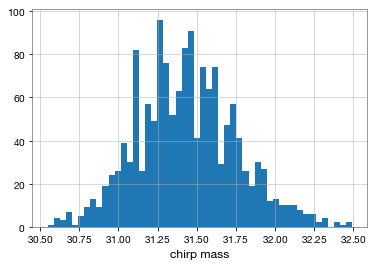

In [22]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=50)
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameter which you sampled in, e.g.

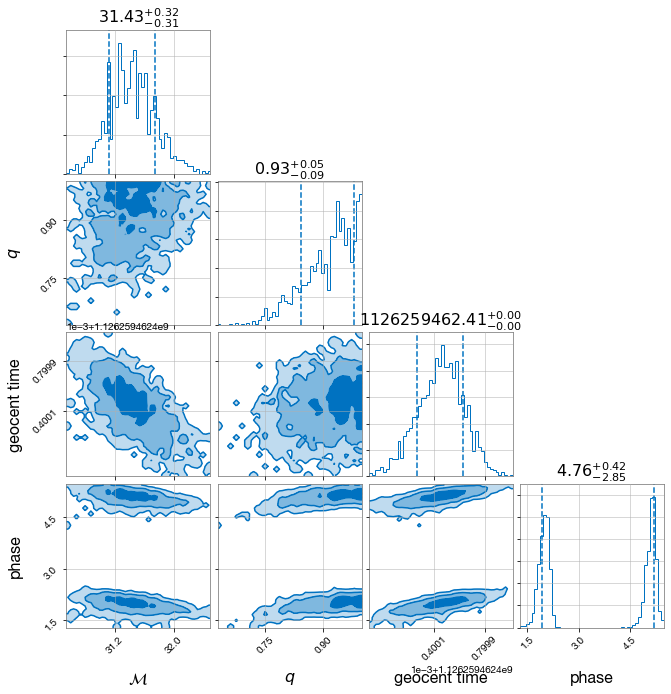

In [23]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/). Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior - if instead we ran the full analysis these agree nicely.

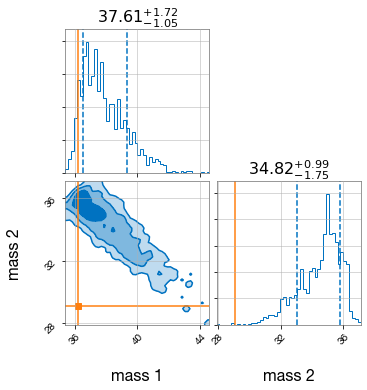

In [24]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

The result object also stores meta data, like the priors

In [25]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [26]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also get out the Bayes factor for the signal vs. Gaussian noise:

In [31]:
print("ln Bayes factor = {} +/- {}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 268.03181516362935 +/- 0.13168911065279812


## Challenge questions
First, let's take a closer look at the result obtained with the run above. What are the means of the chirp mass and mass ratio distributions? What are the medians of the distributions for the components masses? You can use `np.mean` and `np.median` to calculate these.

Now let's expand on this example a bit. Rerun the analysis above but add a suitable prior on the luminosity distance instead of fixing it to be a delta function. You may want to consult Fig. 2 of https://arxiv.org/pdf/1602.03840v2.pdf for the appropriate prior range to use. For the shape of the prior, official LVC analyses assume sources are uniformly distributed in luminosity volume, so this needs to be translated into a `bilby.core.PowerLaw` prior on the distance. Make a corner plot for the distance and chirp mass posteriors. What is the median reported value of the distance posterior, which can be read off the labels of the corner plot? What is the new log Bayes factor for signal vs. Gaussian noise? Again, don't be alarmed if your results do not match those in the paper above. This was not a rigorous run with proper settings that would replicate the LVC results.

Hint: Replace `sample='unif'` with `sample="rwalk", nact=1, walks=1` in your call to `bilby.run_sampler` above. This will take a bit longer than the original run, around ~20 minutes. You should also change the `label` in the call to `run_sampler` to avoid over-writing your results.